# I. Data Exploration for Project 3 ML (Seattle Building Energy Consumption)

## Contents

1) <a href='#Sec.1'>Data Cleaning</a>
    1) <a href='#Sec.1.1'>Columns treatment</a>
    1) <a href='#Sec.1.2'>Rows cleaning</a>
    1) <a href='#Sec.1.3'>Outliers treatment</a>
        1) <a href='#Sec.1.3.1'>Outlier column</a>
        1) <a href='#Sec.1.3.2'>Checking GFA, energy usage, and GHG columns</a>
        1) <a href='#Sec.1.3.3'>Checking NumberofBuildings and NumberofFloors</a>
1) <a href='#Sec.2'>Data Selection and Treatment</a>
    1) <a href='#Sec.2.1'>Selecting the non residential buildings</a>
    1) <a href='#Sec.2.2'>Final check for outliers</a>
    1) <a href='#Sec.2.3'>Imputation</a>
        1) <a href='#Sec.2.3.1'>Retrieving ZipCode using latitude and longitude</a>
        1) <a href='#Sec.2.3.2'>Treating the low occurance of some categories in BuildingType, in PrimaryPropertyType and in LargestPropertyUseType</a>
        1) <a href='#Sec.2.3.3'>Treatment of number of floors and number of building</a>
        1) <a href='#Sec.2.3.4'>Treatment of GFA columns</a>
        1) <a href='#Sec.2.3.5'>Treatment of energy usage columns</a>
    1) <a href='#Sec.2.4'>Final check for missing values</a>
1) <a href='#Sec.3'>Feature Engineering</a>
    1) <a href='#Sec.3.1'>Building age and decade</a>
    1) <a href='#Sec.3.2'>Ground floor area ratio per use type</a>
    1) <a href='#Sec.3.3'>Source of energy</a>
1) <a href='#Sec.4'>Data Analysis</a>
    1) <a href='#Sec.4.1'>Targets of the prediction</a>
    1) <a href='#Sec.4.2'>Consumption of each source of energy</a>
    1) <a href='#Sec.4.3'>Efficiency of transmitting energy from source to site</a></a>
    1) <a href='#Sec.4.4'>Distribution of the buildings on Seattle map</a>
    1) <a href='#Sec.4.5'>GFA distribution</a>
    1) <a href='#Sec.4.6'>Distribution of building age and building decade</a>
    1) <a href='#Sec.4.7'>EnergyStars score distribution</a>
    1) <a href='#Sec.4.8'>NumberofBuildings and NumberofFloors distribution</a>
    1) <a href='#Sec.4.9'>Correlation between all numerical columns</a>
    1) <a href='#Sec.4.10'>Correlation of each categorical columns with SiteEUI(kBtu/sf), SiteEnergyUse(kBtu), TotalGHGEmissions, and GHGEmissionsIntensity</a>
    1) <a href='#Sec.4.11'>Final selection of features for the prediction</a>
1) <a href='#Sec.5'>Extracting the Cleaned Dataset</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import missingno as msno
import collections
import os

from stdnum.ean import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

from collections import Counter

import folium
import folium.plugins
import branca
import branca.colormap as cm

import time

sns.set()

In [2]:
building_df = pd.read_csv('2016_Building_Energy_Benchmarking.csv')
initial_nbr_rows = building_df.shape[0]
initial_nbr_columns = building_df.shape[1]
print('The size of the table is', initial_nbr_rows,
      'rows, and', initial_nbr_columns, 'columns.')
building_df.sort_values(by='OSEBuildingID', inplace=True)

The size of the table is 3376 rows, and 46 columns.


In [3]:
# To display all columns when needed
pd.set_option('display.max_columns', None)

# Function to add infos about the type and null values to .describe function
def df_description(df):
    # General description 
    description = df.describe(include='all', datetime_is_numeric=True)

    # Types and content of the columns
    description_type = pd.DataFrame(df.dtypes, columns=['type']).T
    number_null = (df.shape[0]-description.loc['count'].T)
    percentage_null = (df.shape[0]-description.loc['count'].T)*100/df.shape[0]
    description_null = pd.DataFrame([number_null, percentage_null],
                                    index=['number null', 'percentage null'])

    # Concatenate general, type and null stats
    description = pd.concat([description_type, description_null, description])
    return description

## <font id='Sec.1'> 1. Data Cleaning

In [4]:
print('Percentage of NaN in the dataset equal to',
      sum(building_df.isna().sum()/building_df.shape[0]*100)/building_df.shape[1])
df_description(building_df)

Percentage of NaN in the dataset equal to 12.84772305790233


OSEBuildingID DataYear    BuildingType   PrimaryPropertyType  \
type                    int64    int64          object                object   
number null               0.0      0.0             0.0                   0.0   
percentage null           0.0      0.0             0.0                   0.0   
count                  3376.0   3376.0            3376                  3376   
unique                    NaN      NaN               8                    24   
top                       NaN      NaN  NonResidential  Low-Rise Multifamily   
freq                      NaN      NaN            1460                   987   
mean             21208.991114   2016.0             NaN                   NaN   
std              12223.757015      0.0             NaN                   NaN   
min                       1.0   2016.0             NaN                   NaN   
25%                  19990.75   2016.0             NaN                   NaN   
50%                   23112.0   2016.0             NaN                   NaN   
75%                  25994.25   2016.0             NaN                   NaN   
max                   50226.0   2016.0             NaN                   NaN   

                    PropertyName             Address     City   State  \
type                      object              object   object  object   
number null                  0.0                 0.0      0.0     0.0   
percentage null              0.0                 0.0      0.0     0.0   
count                       3376                3376     3376    3376   
unique                      3362                3354        1       1   
top              Northgate Plaza  2203 Airport Way S  Seattle      WA   
freq                           3                   4     3376    3376   
mean                         NaN                 NaN      NaN     NaN   
std                          NaN                 NaN      NaN     NaN   
min                          NaN                 NaN      NaN     NaN   
25%                          NaN                 NaN      NaN     NaN   
50%                          NaN                 NaN      NaN     NaN   
75%                          NaN                 NaN      NaN     NaN   
max                          NaN                 NaN      NaN     NaN   

                      ZipCode TaxParcelIdentificationNumber  \
type                  float64                        object   
number null              16.0                           0.0   
percentage null      0.473934                           0.0   
count                  3360.0                          3376   
unique                    NaN                          3268   
top                       NaN                    1625049001   
freq                      NaN                             8   
mean             98116.949107                           NaN   
std                 18.615205                           NaN   
min                   98006.0                           NaN   
25%                   98105.0                           NaN   
50%                   98115.0                           NaN   
75%                   98122.0                           NaN   
max                   98272.0                           NaN   

                CouncilDistrictCode Neighborhood   Latitude   Longitude  \
type                          int64       object    float64     float64   
number null                     0.0          0.0        0.0         0.0   
percentage null                 0.0          0.0        0.0         0.0   
count                        3376.0         3376     3376.0      3376.0   
unique                          NaN           19        NaN         NaN   
top                             NaN     DOWNTOWN        NaN         NaN   
freq                            NaN          573        NaN         NaN   
mean                       4.439277          NaN  47.624033 -122.334795   
std                        2.120625          NaN   0.047758    0.027203   
min                    

### <font id='Sec.1.1'> A. Columns treatment

- Removing columns filled only with 0 and null value

In [5]:
# Function to check and remove all columns full of 0 or null values 
def columns_null_zero(df):
    null_zero_df = ((df == 0) | (df.isnull())).sum().reset_index()
    null_zero_df.columns = ['Columns_name', 'Numbers_null_zero']
    print('Number of columns with all values zero or null equal to',
          null_zero_df[null_zero_df['Numbers_null_zero'] == df.shape[0]].shape[0])
    df_reduced = df[list(null_zero_df.loc[null_zero_df['Numbers_null_zero'] != df.shape[0],
                                          'Columns_name'].values)]
    print('After removing those columns, the number of columns left =',
          df_reduced.shape[1])
    return df_reduced

In [6]:
building_df = columns_null_zero(building_df)

Number of columns with all values zero or null equal to 1
After removing those columns, the number of columns left = 45


- YearsENERGYSTARCertified is not much filled, we are going to drop that column as well
- Adress, City, State, TaxParcelIdentificationNumber, DefaultData, ComplianceStatus will not be used for the prediction
- Dropping the weather normalized SiteEUIWN(kBtu/sf), SourceEUIWN(kBtu/sf), and SiteEnergyUseWN(kBtu) since we are not comparing different years consumption and intensity
- Electricity(kWh) and NaturalGas(therms) can be dropped to keep a standardized unit kBtu for all fuel usage features in the database

In [7]:
building_df = building_df.drop(['YearsENERGYSTARCertified'], axis=1)
building_df = building_df.drop(['Address', 'City', 'State',
                                'TaxParcelIdentificationNumber',
                                'DefaultData', 'ComplianceStatus'], axis=1)
building_df = building_df.drop(['SiteEUIWN(kBtu/sf)',
                                'SourceEUIWN(kBtu/sf)',
                                'SiteEnergyUseWN(kBtu)'], axis=1)
building_df = building_df.drop(['Electricity(kWh)',
                                'NaturalGas(therms)'], axis=1)

###  <font id='Sec.1.2'> B. Rows treatment

- Checking for duplicates:

In [8]:
# Function that remove duplicated rows on selected columns
def removing_duplicates(df, df_columns):
    print('The number of duplicated rows on selected columns equal to',
          df.loc[df[df_columns].duplicated(keep=False), :].shape[0])
    df.drop_duplicates(subset=df_columns, inplace=True, ignore_index=True)
    print('After removing those rows, we are left with this number of rows:', df.shape[0])
    return df

In [9]:
building_df = removing_duplicates(building_df, 'OSEBuildingID')

The number of duplicated rows on selected columns equal to 0
After removing those rows, we are left with this number of rows: 3376


- Checking buildings with no entry or 0 value on all energy consumption columns

In [10]:
# Function to check and remove all rows of selected column(s) full of 0 or null values
def rows_zero_null_values(df, df_columns):
    # For multiple columns
    if np.atleast_2d(df_columns.T).shape[0] > 1:
        print('The number of rows with all values equal to 0 or null in the selected columns equal to',
              df[((df_columns == 0) | (df_columns.isnull())).all(axis=1)].shape[0])
        df_cleaned = df[((df_columns != 0) & (df_columns.notnull())).any(axis=1)]
        print('After removing those rows, we are left with this number of rows:',
              df_cleaned.shape[0])
        return df_cleaned
    # For single column
    elif np.atleast_2d(df_columns.T).shape[0] == 1:
        print('The number of rows with all values equal to 0 or null in the selected column equal to',
              df[(df_columns == 0) | (df_columns.isnull())].shape[0])
        df.drop(df[(df_columns == 0) | (df_columns.isnull())].index, inplace=True)
        print('After removing those rows, we are left with this number of rows:',
              df.shape[0])
        return df
    else:
        print('please enter the column(s) name into the function')

In [11]:
columns_list = ['ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
                'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
                'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']
building_df = rows_zero_null_values(building_df, building_df[columns_list])

The number of rows with all values equal to 0 or null in the selected columns equal to 11
After removing those rows, we are left with this number of rows: 3365


- Removing buildings with no entry on SiteEnergyUse(kBtu) or TotalGHGEmissions since those two columns will be the target of the prediction.

In [12]:
print('The number of buildings with no entry on SiteEnergyUse(kBtu) or TotalGHGEmissions equal to',
      building_df[((building_df['SiteEnergyUse(kBtu)'].isnull())
                   | (building_df['TotalGHGEmissions'].isnull()))].shape[0])
building_df = building_df[~((building_df['SiteEnergyUse(kBtu)'].isnull())
                            | (building_df['TotalGHGEmissions'].isnull()))]
print('After removing those buildings, we are left with this number of rows:',
      building_df.shape[0])

The number of buildings with no entry on SiteEnergyUse(kBtu) or TotalGHGEmissions equal to 4
After removing those buildings, we are left with this number of rows: 3361


- Checking and deleting buildings with negative values in any feature except latitude and longitude columns

In [13]:
columns_list = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
                'PropertyGFAParking', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
                'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
                'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
                'TotalGHGEmissions', 'GHGEmissionsIntensity']
print('Number of nuildings with negative values in any numerical feature:',
      building_df[(building_df[columns_list] < 0).any(axis=1)].shape[0])
condition = building_df[(building_df[columns_list] < 0).any(axis=1)]
building_df.drop(condition.index, inplace=True)
print('After removing those buildings, we are left with this number of rows:',
      building_df.shape[0])

Number of nuildings with negative values in any numerical feature: 1
After removing those buildings, we are left with this number of rows: 3360


###  <font id='Sec.1.3'> C. Outliers treatment

####  <font id='Sec.1.3.1'> a) Outlier column
    
Columns outliers classify a building as high or low outlier depending if the building energy use intensity EUI is in the 5% highest intensity or in the 5% lowest intensity respectively. We are going to drop those low and high building from the database. Then drop the outliers column.

In [14]:
print('The number of buildings with the highest or lowest 5% in terms of EUI equal to',
      building_df[building_df['Outlier'].notna()].shape[0])
building_df = building_df[building_df['Outlier'].isna()]
print('After removing those buildings, we are left with this number of rows:',
      building_df.shape[0])
building_df = building_df.drop(['Outlier'], axis=1)

The number of buildings with the highest or lowest 5% in terms of EUI equal to 32
After removing those buildings, we are left with this number of rows: 3328


####  <font id='Sec.1.3.2'> b) Checking GFA, energy usage, and GHG columns

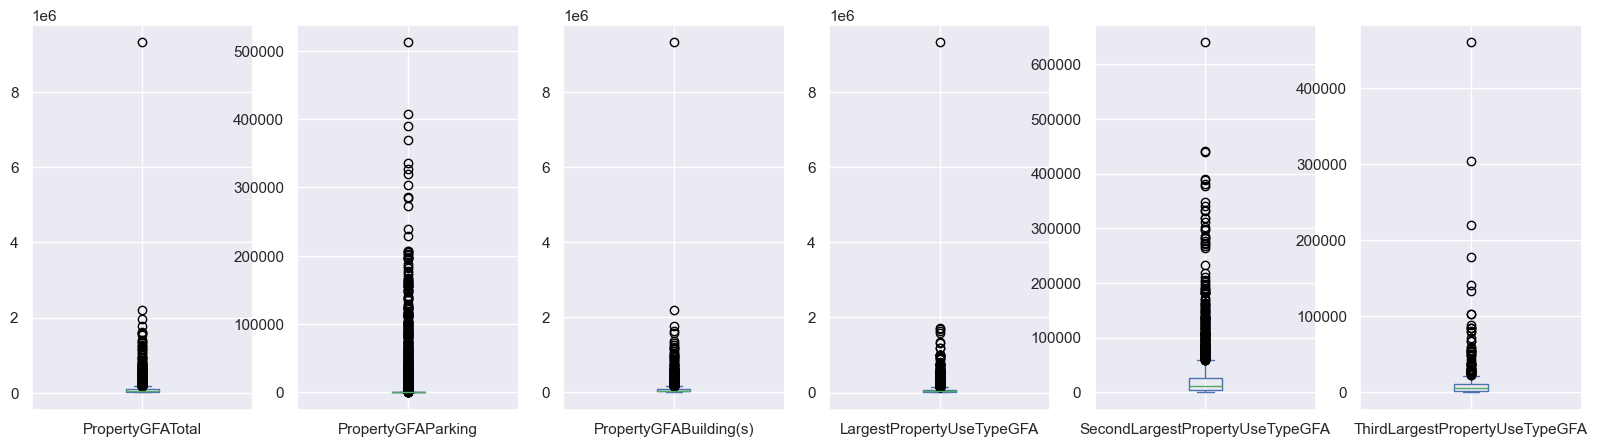

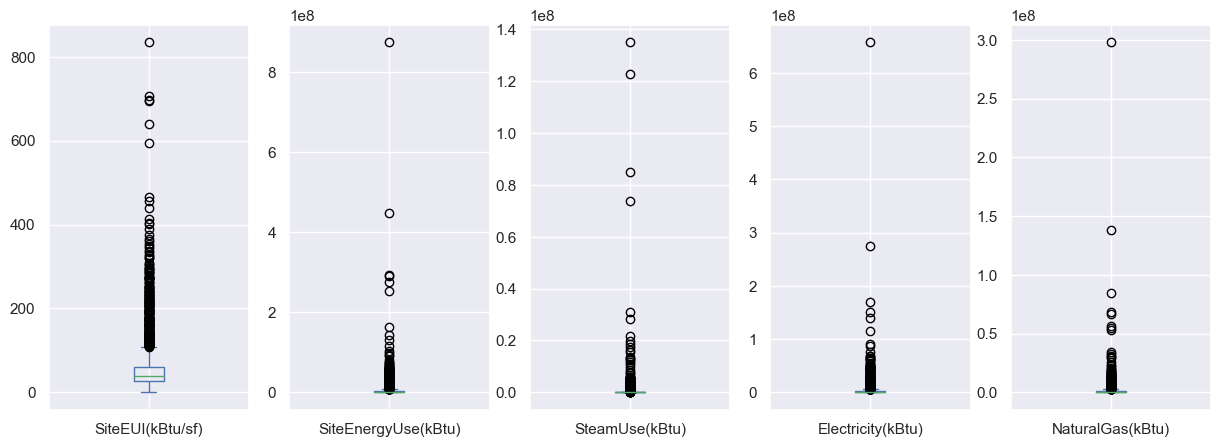

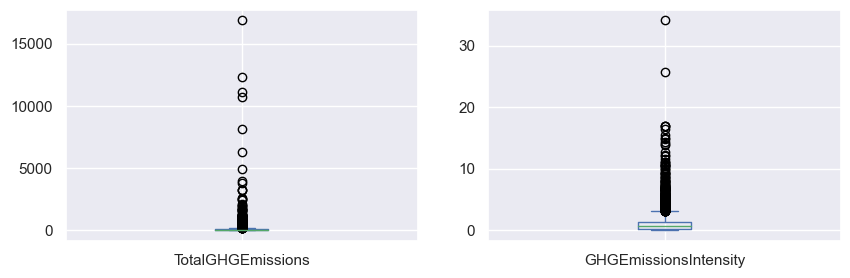

In [15]:
columns_list = ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA']
building_df[columns_list].plot(kind='box', subplots=True,
                               figsize=(20, 5), layout=(1, 6))
plt.show()
columns_list = ['SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
                'Electricity(kBtu)', 'NaturalGas(kBtu)']
building_df[columns_list].plot(kind='box', subplots=True,
                               figsize=(15, 5), layout=(1, 5))
plt.show()
columns_list = ['TotalGHGEmissions','GHGEmissionsIntensity']
building_df[columns_list].plot(kind='box', subplots=True,
                               figsize=(10, 3), layout=(1, 2))
plt.show()

Dropping all outliers appearing at least 2 times outside the interval Q1-5*IQR -- Q3+5*IQR on columns 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity'

In [16]:
# Function that check for outliers on multiple columns and count the number of times an outlier appeared.
# If an outlier appeared at least n times, we drop that outlier from the dataset.
def Outliers_Limits(df, col_list, n):
    indexes_outliers = []
    
    # Checking for outliers and getting their index
    for col in col_list:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 5*IQR
        upper_limit = Q3 + 5*IQR
        list_outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)].index
        indexes_outliers.extend(list_outliers)

    # Counting the number of time an outlier appeared
    indexes_outliers = Counter(indexes_outliers)

    # Selection of outliers appearing at least n time
    multiple_outliers = list( k for k, v in indexes_outliers.items() if v > n )
    print('Number of outliers to remove: {}'.format(len(multiple_outliers)))

    # Dropping those outliers that appeared at least n time
    df.drop(multiple_outliers, axis=0, inplace=True)

In [17]:
columns_list = ['PropertyGFATotal', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'Electricity(kBtu)',
                'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']
Outliers_Limits(building_df, columns_list, 1)
print('After removing those outliers, we are left with this number of buildings:',
      building_df.shape[0])

Number of outliers to remove: 216
After removing those outliers, we are left with this number of buildings: 3112


####  <font id='Sec.1.3.3'> c) Checking NumberofBuildings and NumberofFloors:

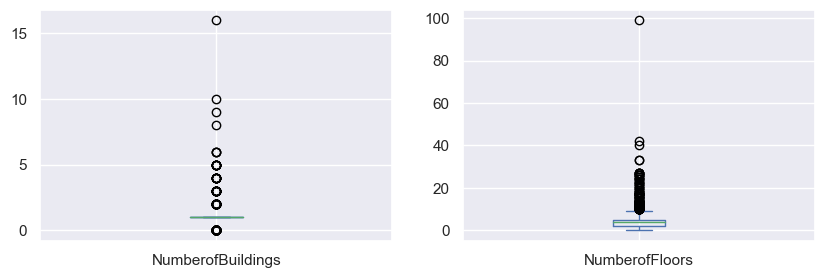

In [18]:
building_df[['NumberofBuildings', 'NumberofFloors']].plot(kind='box', subplots=True,
                                                          figsize=(10, 3), layout=(1, 2))
plt.show()

In [19]:
building_df[(building_df['NumberofFloors'] > 50)]

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
1356          21611      2016  NonResidential    Worship Facility   

                        PropertyName  ZipCode  CouncilDistrictCode  \
1356  Seattle Chinese Baptist Church  98108.0                    2   

          Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
1356  GREATER DUWAMISH  47.55072 -122.30265       1977                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
1356              99             21948                   0   

      PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
1356                   21948          Worship Facility       Worship Facility   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
1356                    21948.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
1356                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
1356                             NaN             80.0              14.9   

      SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu)  SteamUse(kBtu)  \
1356           46.599998          326001.1875             0.0   

      Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
1356           326001.0               0.0               2.27   

      GHGEmissionsIntensity  
1356                    0.1

Changing the 99 floor Seattle Chinese Baptist Church to NaN.

In [20]:
building_df.loc[building_df[(building_df['NumberofFloors'] > 80)].index,
                'NumberofFloors'] = np.nan

##  <font id='Sec.2'> 2. Data Selection and Treatment

In [21]:
print('Percentage of NaN in the dataset equal to',
      sum(building_df.isna().sum()/building_df.shape[0]*100)/building_df.shape[1])
building_df = building_df.reset_index(drop=True)
df_description(building_df)

Percentage of NaN in the dataset equal to 9.267553020565552


OSEBuildingID DataYear    BuildingType   PrimaryPropertyType  \
type                    int64    int64          object                object   
number null               0.0      0.0             0.0                   0.0   
percentage null           0.0      0.0             0.0                   0.0   
count                  3112.0   3112.0            3112                  3112   
unique                    NaN      NaN               8                    24   
top                       NaN      NaN  NonResidential  Low-Rise Multifamily   
freq                      NaN      NaN            1279                   967   
mean             21667.851864   2016.0             NaN                   NaN   
std              11558.326719      0.0             NaN                   NaN   
min                       1.0   2016.0             NaN                   NaN   
25%                  20241.75   2016.0             NaN                   NaN   
50%                   23272.5   2016.0             NaN                   NaN   
75%                   26020.0   2016.0             NaN                   NaN   
max                   50226.0   2016.0             NaN                   NaN   

                    PropertyName       ZipCode CouncilDistrictCode  \
type                      object       float64               int64   
number null                  0.0          13.0                 0.0   
percentage null              0.0      0.417738                 0.0   
count                       3112        3099.0              3112.0   
unique                      3099           NaN                 NaN   
top              Northgate Plaza           NaN                 NaN   
freq                           3           NaN                 NaN   
mean                         NaN  98117.242336            4.390424   
std                          NaN     18.667169            2.109707   
min                          NaN       98006.0                 1.0   
25%                          NaN       98105.0                 3.0   
50%                          NaN       98115.0                 4.0   
75%                          NaN       98122.0                 7.0   
max                          NaN       98272.0                 7.0   

                Neighborhood   Latitude   Longitude    YearBuilt  \
type                  object    float64     float64        int64   
number null              0.0        0.0         0.0          0.0   
percentage null          0.0        0.0         0.0          0.0   
count                   3112     3112.0      3112.0       3112.0   
unique                    19        NaN         NaN          NaN   
top                 DOWNTOWN        NaN         NaN          NaN   
freq                     476        NaN         NaN          NaN   
mean                     NaN  47.624493 -122.334948  1967.977828   
std                      NaN   0.048476    0.027534    33.089242   
min                      NaN   47.49917  -122.41425       1900.0   
25%                      NaN  47.599535 -122.351722       1948.0   
50%                      NaN  47.619415 -122.332185       1974.0   
75%                      NaN  47.658473 -122.318938       1996.0   
max                      NaN   47.73387 -122.220966       2015.0   

                NumberofBuildings NumberofFloors PropertyGFATotal  \
type                      float64        float64            int64   
number null                   0.0            1.0              0.0   
percentage null               0.0       0.032134              0.0   
count                      3112.0         3111.0           3112.0   
unique                        NaN            NaN              NaN   
top                           NaN            NaN              NaN   
freq                          NaN            NaN              NaN   
mean                     1.034383       4.124076     67549.784383   
std                      0.542421       3.329885     64810.956063   
min                           0.0            0.0     

###  <font id='Sec.2.1'> A. Selecting the non residential buildings

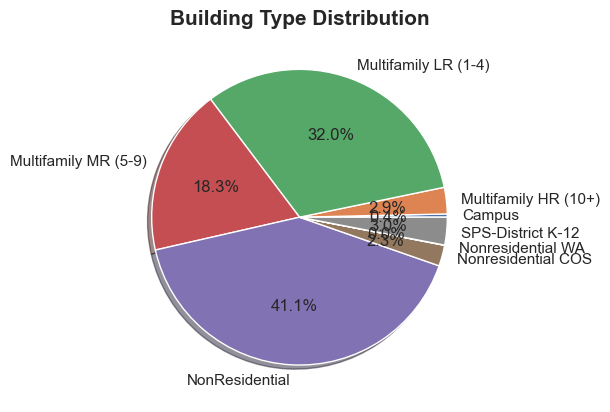

In [22]:
plt.pie(building_df.groupby(by='BuildingType').size(),
        labels=building_df.groupby(by='BuildingType').size().index, 
        startangle=0, 
        shadow=True,
        autopct='%1.1f%%')
plt.title('Building Type Distribution', fontsize=15, fontweight='bold')
plt.show()

- Removing the Multifamily buildings from our database since the project is about the energy consumption and emissions of the non-residential building.

Multifamily buildings to be dropped equal to 1656
After selecting the non-residential buildings, we are left with 1456 buildings.


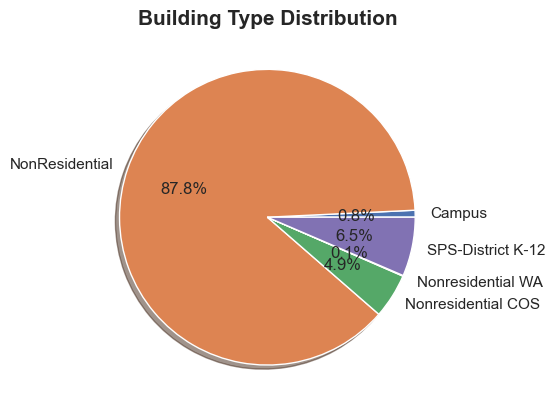

In [23]:
condition = building_df['BuildingType'].isin([hab for hab in building_df['BuildingType'].unique() if hab.startswith('Multifamily')])
print('Multifamily buildings to be dropped equal to', building_df[condition].shape[0])
building_df = building_df[~condition]
print('After selecting the non-residential buildings, we are left with {} buildings.'
      .format(building_df.shape[0]))

plt.pie(building_df.groupby(by='BuildingType').size(),
        labels=building_df.groupby(by='BuildingType').size().index, 
        startangle=0, 
        shadow=True,
        autopct='%1.1f%%')
plt.title('Building Type Distribution', fontsize=15, fontweight='bold')
plt.show()

- Checking the PrimaryPropertyType of each building type

In [24]:
display((building_df[['BuildingType', 'PrimaryPropertyType']])
        .groupby(['BuildingType', 'PrimaryPropertyType']).size())

BuildingType        PrimaryPropertyType        
Campus              K-12 School                      4
                    Low-Rise Multifamily             1
                    Mixed Use Property               2
                    Other                            3
                    University                       1
NonResidential      Distribution Center             49
                    Hospital                         1
                    Hotel                           63
                    K-12 School                     38
                    Laboratory                       3
                    Large Office                   109
                    Low-Rise Multifamily             1
                    Medical Office                  31
                    Mixed Use Property              85
                    Other                          156
                    Refrigerated Warehouse          12
                    Residence Hall                  21
                 

We still see some multifamily classification as well residence hall in PrimaryPropertyType; We are going to drop those buildings as well.

Left over multifamily buildings to be dropped equal to 86
After removing those buildings, we are left with 1370 buildings.
PrimaryPropertyType
Small- and Mid-Sized Office    286
Other                          205
Warehouse                      185
K-12 School                    135
Large Office                   110
Mixed Use Property              95
Retail Store                    83
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     33
Medical Office                  32
Self-Storage Facility           28
University                      16
Senior Care Community           14
Refrigerated Warehouse          12
Restaurant                       9
Office                           3
Laboratory                       3
Hospital                         1
Name: OSEBuildingID, dtype: int64


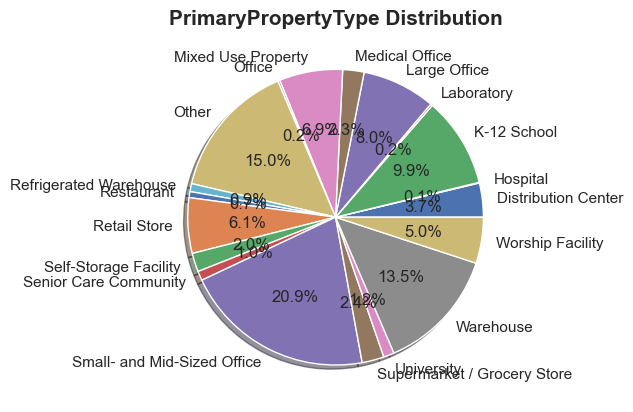

In [25]:
condition = building_df['PrimaryPropertyType']\
            .isin([hab for hab in building_df['PrimaryPropertyType'].unique() if ((hab.endswith('Multifamily'))
                                                                                  | (hab == 'Hotel')
                                                                                  | (hab == 'Residence Hall'))])
print('Left over multifamily buildings to be dropped equal to',
      building_df[condition].shape[0])
building_df = building_df[~condition]
print('After removing those buildings, we are left with {} buildings.'
      .format(building_df.shape[0]))

print(building_df.groupby(by='PrimaryPropertyType').nunique().sort_values('OSEBuildingID',
                                                                          ascending=False)['OSEBuildingID'])

plt.pie(building_df.groupby(by='PrimaryPropertyType').size(),
        labels=building_df.groupby(by='PrimaryPropertyType').size().index, 
        startangle=0, 
        shadow=True,
        autopct='%1.1f%%')
plt.title('PrimaryPropertyType Distribution', fontsize=15, fontweight='bold')
plt.show()

We see low occurence of Hospital, Laboratory, Office, and Restaurant with entries of less than 10 buildings. Those can lower the performance of the ML models. We will treat them later.

###  <font id='Sec.2.2'> B. Final check for outliers

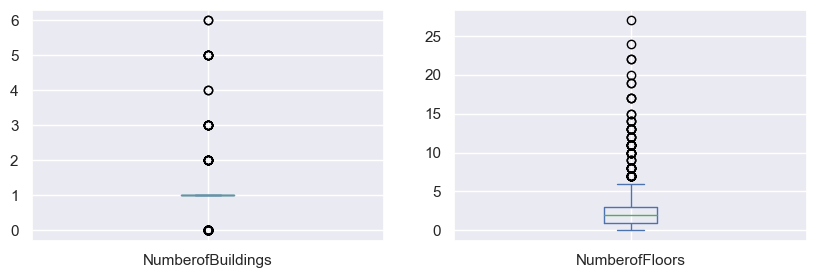

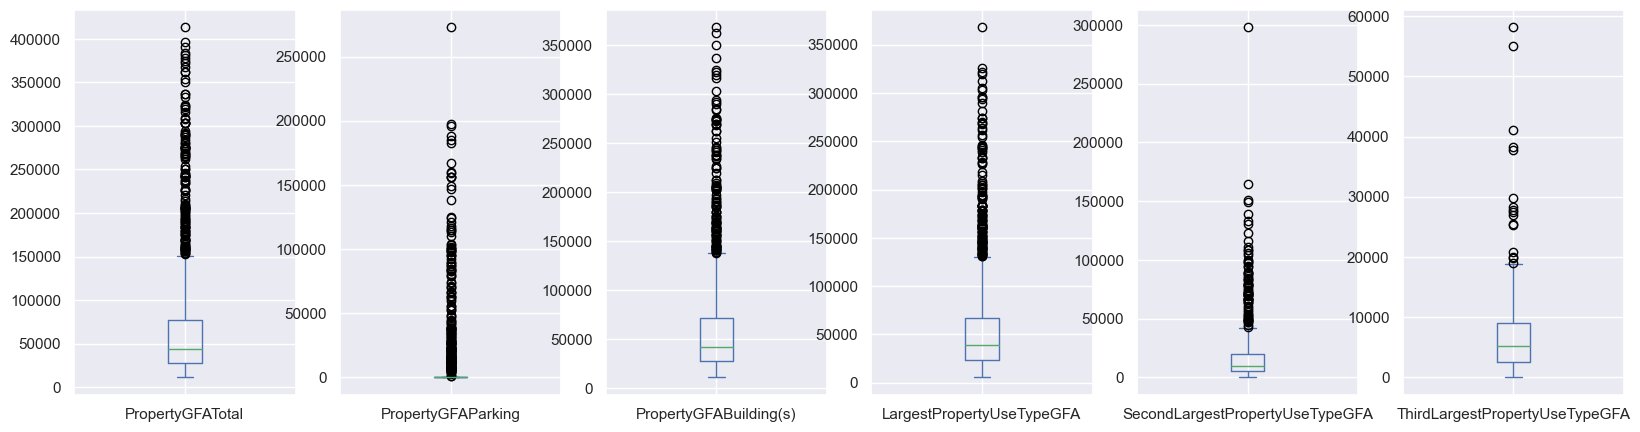

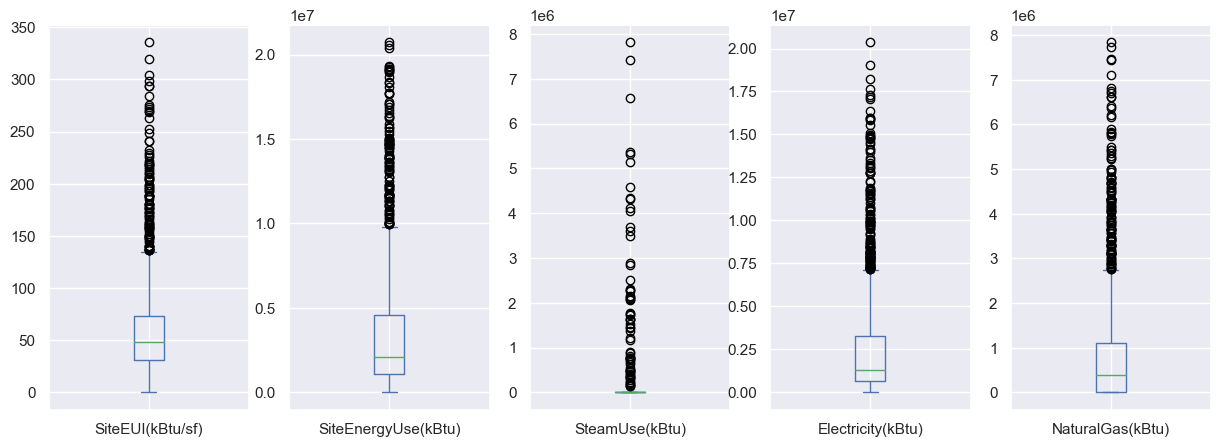

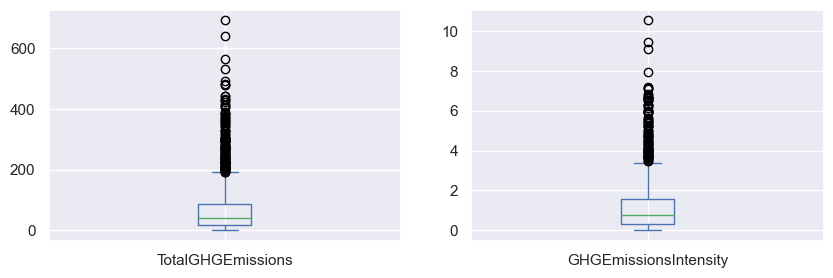

In [26]:
building_df[['NumberofBuildings', 'NumberofFloors']].plot(kind='box', subplots=True,
                                                          figsize=(10, 3), layout=(1, 2))
plt.show()
building_df[['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
             'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
             'ThirdLargestPropertyUseTypeGFA']].plot(kind='box', subplots=True,
                                                     figsize=(20, 5), layout=(1, 6))
plt.show()
columns_list = ['SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
                'Electricity(kBtu)', 'NaturalGas(kBtu)']
building_df[columns_list].plot(kind='box', subplots=True,
                               figsize=(15, 5), layout=(1, 5))
plt.show()
columns_list = ['TotalGHGEmissions','GHGEmissionsIntensity']
building_df[columns_list].plot(kind='box', subplots=True,
                               figsize=(10, 3), layout=(1, 2))
plt.show()

We still have some outliers, we will remove again the outliers that appear at least 2 times in those columns:

In [27]:
columns_list = ['PropertyGFATotal', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
                'Electricity(kBtu)', 'NaturalGas(kBtu)',
                'TotalGHGEmissions', 'GHGEmissionsIntensity']
Outliers_Limits(building_df, columns_list, 1)

Number of outliers to remove: 22


In [28]:
# Limiting SiteEnergyUse to 2*1E7
condition = building_df[building_df['SiteEnergyUse(kBtu)'] > 2*1E7]
building_df.drop(condition.index, inplace=True)

###  <font id='Sec.2.3'> C. Imputation

In [29]:
print('Percentage of NaN in the dataset equal to',
      sum(building_df.isna().sum()/building_df.shape[0]*100)/building_df.shape[1])
df_description(building_df)

Percentage of NaN in the dataset equal to 9.419079435783223


OSEBuildingID DataYear    BuildingType  \
type                    int64    int64          object   
number null               0.0      0.0             0.0   
percentage null           0.0      0.0             0.0   
count                  1347.0   1347.0            1347   
unique                    NaN      NaN               5   
top                       NaN      NaN  NonResidential   
freq                      NaN      NaN            1174   
mean             17187.165553   2016.0             NaN   
std              12807.524486      0.0             NaN   
min                       9.0   2016.0             NaN   
25%                     706.5   2016.0             NaN   
50%                   21425.0   2016.0             NaN   
75%                   24629.5   2016.0             NaN   
max                   50226.0   2016.0             NaN   

                         PrimaryPropertyType PropertyName       ZipCode  \
type                                  object       object       float64   
number null                              0.0          0.0          13.0   
percentage null                          0.0          0.0      0.965108   
count                                   1347         1347        1334.0   
unique                                    19         1344           NaN   
top              Small- and Mid-Sized Office  Airport Way           NaN   
freq                                     286            2           NaN   
mean                                     NaN          NaN  98117.488006   
std                                      NaN          NaN     18.030925   
min                                      NaN          NaN       98006.0   
25%                                      NaN          NaN       98105.0   
50%                                      NaN          NaN       98115.0   
75%                                      NaN          NaN       98125.0   
max                                      NaN          NaN       98199.0   

                CouncilDistrictCode      Neighborhood   Latitude   Longitude  \
type                          int64            object    float64     float64   
number null                     0.0               0.0        0.0         0.0   
percentage null                 0.0               0.0        0.0         0.0   
count                        1347.0              1347     1347.0      1347.0   
unique                          NaN                19        NaN         NaN   
top                             NaN  GREATER DUWAMISH        NaN         NaN   
freq                            NaN               322        NaN         NaN   
mean                       4.161841               NaN  47.614698 -122.333239   
std                        2.182042               NaN   0.050516    0.025706   
min                             1.0               NaN   47.49917  -122.41182   
25%                             2.0               NaN   47.57887 -122.345565   
50%                             4.0               NaN   47.61159  -122.33248   
75%                             7.0               NaN  47.651085 -122.321155   
max                             7.0               NaN   47.73387  -122.25864   

                   YearBuilt NumberofBuildings NumberofFloors  \
type                   int64           float64        float64   
number null              0.0               0.0            1.0   
percentage null          0.0               0.0       0.074239   
count                 1347.0            1347.0         1346.0   
unique                   NaN               NaN            NaN   
top                      NaN               NaN            NaN   
freq                     NaN               NaN            NaN   
mean             1959.641425          1.023756       2.780832   
std                32.102661          0.447247       2.442856   
min                   1900.0               0.0            0.0   
25%                   1929.0               1.0            1.0   
50%                   1963.0          

#### <font id='Sec.2.3.1'> a) Retrieving ZipCode using Latitude and Longitude

In [30]:
# Let's start with resetting the index of our database
building_df = building_df.reset_index(drop=True)

# Creating a database where 'ZipCode', 'Latitude', and 'Longitude' are not null
columns_list = ['ZipCode', 'Latitude', 'Longitude']
columns_list_data = ['Latitude', 'Longitude']
columns_list_target = 'ZipCode'
data = building_df[(building_df[columns_list].notna()).all(axis=1)].reset_index(drop=True)

# Selecting 100% of that selected database
sample_index = np.random.randint(data.shape[0], size=int(data.shape[0]*1))
sample_data = data[columns_list_data].iloc[sample_index].reset_index(drop=True)
sample_target = data[columns_list_target].iloc[sample_index].reset_index(drop=True)

# Divide the data into 80% training and 20% testing
xtrain, xtest, ytrain, ytest = train_test_split(sample_data, sample_target, train_size=0.8)

# Fitting using RandomForestClassifier
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(xtrain, ytrain)
print('Error using RandomForestClassifier equal to', (1 - classifier.score(xtest, ytest)))

Error using RandomForestClassifier equal to 0.041198501872659166


We got low error from the classifier, we will proceed to fill the missing values in zipcode:

In [31]:
# Creating a database where only null in 'ZipCode', and no null value on 'Latitude' and 'Longitude'
data_null = building_df[((building_df[columns_list_data].notna()).all(axis=1))
                        & (building_df[columns_list_target].isna())]
data_null = data_null[columns_list_data]
data_null_index = data_null.index
data_null.columns = columns_list_data

# Predicting the value of 'ZipCode' from 'Latitude' and 'Longitude' using the model
data_null[columns_list_target] = classifier.predict(data_null)

# Adding those values to the main database
building_df.loc[data_null_index,columns_list_target] = data_null[columns_list_target]

#### <font id='Sec.2.3.2'> b) Treating the low occurance of some categories in BuildingType, in PrimaryPropertyType and in LargestPropertyUseType

In [32]:
print(building_df.groupby(by='BuildingType').nunique().sort_values('OSEBuildingID',
                                                                   ascending=False)['OSEBuildingID'])
print(building_df.groupby(by='PrimaryPropertyType').nunique().sort_values('OSEBuildingID',
                                                                          ascending=False)['OSEBuildingID'])
print(building_df.groupby(by='LargestPropertyUseType').nunique().sort_values('OSEBuildingID',
                                                                             ascending=False)['OSEBuildingID'])

BuildingType
NonResidential        1174
SPS-District K-12       92
Nonresidential COS      70
Campus                  10
Nonresidential WA        1
Name: OSEBuildingID, dtype: int64
PrimaryPropertyType
Small- and Mid-Sized Office    286
Other                          203
Warehouse                      185
K-12 School                    133
Large Office                    99
Mixed Use Property              94
Retail Store                    81
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     32
Medical Office                  29
Self-Storage Facility           28
University                      15
Senior Care Community           14
Refrigerated Warehouse          12
Restaurant                       9
Office                           3
Laboratory                       3
Hospital                         1
Name: OSEBuildingID, dtype: int64
LargestPropertyUseType
Office                                                  414
Non-Refrigerated

- For BuildingType, we see that Nonresidential WA is appearing one time, we will rename it Nonresidential.
- For PrimaryPropertyType and LargestPropertyUseType, we fix the value of occurance/frequency to 5, i.e. every category appearing less than 5 times will be replaced by NaN.

In [33]:
# Merging the low occurance of some BuildingType with other high occurance
building_df.loc[(building_df[building_df['BuildingType'] == 'Nonresidential WA'].index),
                'BuildingType'] = 'NonResidential'

In [34]:
# Replacing the low occurance of some PrimaryPropertyType by NaN
cat_df = pd.DataFrame(building_df.groupby(by='PrimaryPropertyType').nunique().sort_values('OSEBuildingID',
                                                                                          ascending=False)['OSEBuildingID'])
cat_list = list(cat_df[cat_df['OSEBuildingID'] <= 5].index)
for cat in cat_list:
    building_df.loc[(building_df[building_df['PrimaryPropertyType'] == cat].index),
                    'PrimaryPropertyType'] = np.nan

In [35]:
# Replacing the low occurance of some LargestPropertyUseType by NaN
cat_df = pd.DataFrame(building_df.groupby(by='LargestPropertyUseType').nunique().sort_values('OSEBuildingID',
                                                                                             ascending=False)['OSEBuildingID'])
cat_list = list(cat_df[cat_df['OSEBuildingID'] <= 5].index)
for cat in cat_list:
    building_df.loc[(building_df[building_df['LargestPropertyUseType'] == cat].index),
                    'LargestPropertyUseType'] = np.nan

- Comparing missing values in largestPropertyType and PrimaryPropertyType
    - if one value of the two columns is missing, we replace the missing value by the other column value.

In [36]:
# building_df[building_df[['PrimaryPropertyType']].isna]
display((building_df[['PrimaryPropertyType',
                      'LargestPropertyUseType']].notna()).groupby(['PrimaryPropertyType',
                                                                   'LargestPropertyUseType']).size())

PrimaryPropertyType  LargestPropertyUseType
False                False                        4
                     True                         3
True                 False                       80
                     True                      1260
dtype: int64

In [37]:
index_check = building_df[(building_df['PrimaryPropertyType'].notna()
                           & building_df['LargestPropertyUseType'].isna())].index
building_df.loc[index_check,
                'LargestPropertyUseType'] = building_df.loc[index_check,
                                                            'PrimaryPropertyType'].values
index_check = building_df[(building_df['PrimaryPropertyType'].isna()
                           & building_df['LargestPropertyUseType'].notna())].index
building_df.loc[index_check,
                'PrimaryPropertyType'] = building_df.loc[index_check,
                                                         'LargestPropertyUseType'].values

- Final treatment of PrimaryPropertyType and LargestPropertyUseType

In [38]:
print(building_df.groupby(by='PrimaryPropertyType').nunique().sort_values('OSEBuildingID',
                                                                          ascending=False)['OSEBuildingID'])
print(building_df.groupby(by='LargestPropertyUseType').nunique().sort_values('OSEBuildingID',
                                                                             ascending=False)['OSEBuildingID'])

PrimaryPropertyType
Small- and Mid-Sized Office    286
Other                          203
Warehouse                      185
K-12 School                    133
Large Office                    99
Mixed Use Property              94
Retail Store                    81
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     32
Medical Office                  29
Self-Storage Facility           28
University                      15
Senior Care Community           14
Refrigerated Warehouse          12
Restaurant                       9
Office                           3
Name: OSEBuildingID, dtype: int64
LargestPropertyUseType
Office                                             414
Non-Refrigerated Warehouse                         197
Other                                              145
K-12 School                                        133
Retail Store                                        89
Worship Facility                                    6

- For PrimaryPropertyType, we will merge Office with Small- and Mid-Sized Office
- For LargestPropertyUseType, we will merge Supermarket / Grocery Store with Supermarket/Grocery Store, and Small- and Mid-Sized Office with Office.

In [39]:
# Merging the low occurance of some BuildingType with other high occurance
building_df.loc[(building_df[building_df['PrimaryPropertyType'] == 'Office'].index),
                'PrimaryPropertyType'] = 'Small- and Mid-Sized Office'
building_df.loc[(building_df[building_df['LargestPropertyUseType'] == 'Supermarket / Grocery Store'].index),
                'LargestPropertyUseType'] = 'Supermarket/Grocery Store'
building_df.loc[(building_df[building_df['LargestPropertyUseType'] == 'Small- and Mid-Sized Office'].index),
                'LargestPropertyUseType'] = 'Office'

- 4 buildings left to be treated, we will take a look and check their BuildingType, ListOfAllPropertyUseTypes, and SecondLargestPropertyUseType

In [40]:
building_df.loc[(building_df[building_df[['PrimaryPropertyType',
                                          'LargestPropertyUseType']].isna().any(axis=1)].index),
                ['PropertyName', 'BuildingType', 'ListOfAllPropertyUseTypes',
                 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType']]

PropertyName    BuildingType  \
190       Rosen Building - SEDO  NonResidential   
456              1100 Olive Lab  NonResidential   
1116  Park West Skilled Nursing  NonResidential   
1268   Environmental Laboratory  NonResidential   

                  ListOfAllPropertyUseTypes PrimaryPropertyType  \
190                 Data Center, Laboratory                 NaN   
456                              Laboratory                 NaN   
1116  Hospital (General Medical & Surgical)                 NaN   
1268                      Laboratory, Other                 NaN   

     LargestPropertyUseType SecondLargestPropertyUseType  
190                     NaN                  Data Center  
456                     NaN                          NaN  
1116                    NaN                          NaN  
1268                    NaN                        Other

    Since they belong to Laboratory and Hospital as PrimaryPropertyType and LargestPropertyUseType, and because these two categories are not represented in the database, we will drop these 4 buildings.

In [41]:
condition = building_df[building_df[['PrimaryPropertyType', 'LargestPropertyUseType']].isna().any(axis=1)]
building_df.drop(condition.index, inplace=True)

#### <font id='Sec.2.3.3'> c) Treatment of number of floors or number of building
- Replacing the entries with number of floors and number of buildings equal to zero by the median of each PrimaryPropertyType.

In [42]:
building_df['NumberofBuildings'].replace(0, np.nan, inplace=True)
building_df['NumberofFloors'].replace(0, np.nan, inplace=True)
building_df['NumberofBuildings'].fillna(building_df.groupby('PrimaryPropertyType')['NumberofBuildings'].transform('median').round(0), inplace=True)
building_df['NumberofFloors'].fillna(building_df.groupby('PrimaryPropertyType')['NumberofFloors'].transform('median').round(0), inplace=True)

#### <font id='Sec.2.3.4'> d) Treatment of GFA columns
- Checking if sum of PropertyGFAParking and PropertyGFABuilding(s) equal to PropertyGFATotal

count    1343.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


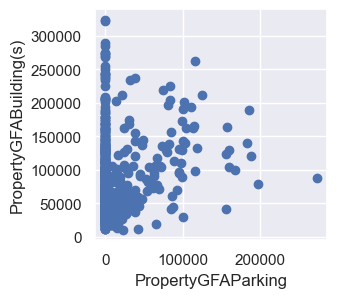

In [43]:
print((building_df['PropertyGFATotal']/(building_df['PropertyGFAParking']+building_df['PropertyGFABuilding(s)'])).describe())
plt.figure(figsize=(3, 3))
plt.plot(building_df['PropertyGFAParking'], building_df['PropertyGFABuilding(s)'], 'o')
plt.xlabel('PropertyGFAParking')
plt.ylabel('PropertyGFABuilding(s)')
plt.show()

PropertyGFATotal equal to PropertyGFAParking+PropertyGFABuilding(s).

- Checking the missing values in LargestPropertyUseTypeGFA

In [44]:
building_df[building_df['LargestPropertyUseTypeGFA'].isna()]

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
204             496      2016  NonResidential        Self-Storage Facility   
1094          25568      2016  NonResidential  Small- and Mid-Sized Office   
1111          25711      2016  NonResidential                   Restaurant   

                          PropertyName  ZipCode  CouncilDistrictCode  \
204                   Market St Center  98107.0                    6   
1094               Talon Northlake LLC  98103.0                    4   
1111  BUSH GARDEN - RESTURANT & LOUNGE  98104.0                    2   

     Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
204       BALLARD  47.66838 -122.39310       1946                2.0   
1094   LAKE UNION  47.64747 -122.34086       2008                1.0   
1111     DOWNTOWN  47.59697 -122.32474       1913                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
204              2.0            111445                   0   
1094             4.0             48350                   0   
1111             3.0             28800                   0   

      PropertyGFABuilding(s)  \
204                   111445   
1094                   48350   
1111                   28800   

                              ListOfAllPropertyUseTypes  \
204   Fitness Center/Health Club/Gym, Office, Other ...   
1094                                             Office   
1111                                         Restaurant   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
204   Self-Storage Facility                        NaN   
1094                 Office                        NaN   
1111             Restaurant                        NaN   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
204                           NaN                              NaN   
1094                          NaN                              NaN   
1111                          NaN                              NaN   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
204                          NaN                             NaN   
1094                         NaN                             NaN   
1111                         NaN                             NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  \
204               NaN         47.799999          103.000000   
1094             45.0         72.199997          226.600006   
1111              NaN         31.200001           62.000000   

      SiteEnergyUse(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  \
204          5.697472e+06             0.0          3007514.0   
1094         3.168131e+06             0.0          3168131.0   
1111         8.999242e+05             0.0           402907.0   

      NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
204          2689958.0             163.83                   1.47  
1094               0.0              22.09                   0.46  
1111          497017.0              29.21                   1.01

    Dropping building ID 496 and filling the other two with the value in PropertyGFATotal

In [45]:
building_df.drop(building_df[building_df['OSEBuildingID'] == 496].index, inplace=True)
building_df.loc[building_df[building_df['LargestPropertyUseTypeGFA'].isna()].index,
                'LargestPropertyUseTypeGFA'] = building_df.loc[building_df[building_df['LargestPropertyUseTypeGFA'].isna()].index,
                                                               'PropertyGFATotal']

- Checking the missing values in SecondLargestPropertyUseType and SecondLargestPropertyUseTypeGFA;
- Checking the missing values in ThirdLargestPropertyUseType and ThirdLargestPropertyUseTypeGFA;
- Checking the missing values in SecondLargestPropertyUseTypeGFA and ThirdLargestPropertyUseTypeGFA;

In [46]:
display((building_df[['SecondLargestPropertyUseType',
                      'SecondLargestPropertyUseTypeGFA']].notna()).groupby(['SecondLargestPropertyUseType',
                                                                            'SecondLargestPropertyUseTypeGFA']).size())
display((building_df[['ThirdLargestPropertyUseType',
                      'ThirdLargestPropertyUseTypeGFA']].notna()).groupby(['ThirdLargestPropertyUseType',
                                                                           'ThirdLargestPropertyUseTypeGFA']).size())
display((building_df[['SecondLargestPropertyUseTypeGFA',
                      'ThirdLargestPropertyUseTypeGFA']].notna()).groupby(['SecondLargestPropertyUseTypeGFA',
                                                                           'ThirdLargestPropertyUseTypeGFA']).size())

SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA
False                         False                              683
True                          True                               659
dtype: int64

ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA
False                        False                             1090
True                         True                               252
dtype: int64

SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA
False                            False                             683
True                             False                             407
                                 True                              252
dtype: int64

    There is either a value in both or missing values in both. We will proceed to filling the missing values.

- If SecondLargestPropertyUseTypeGFA or ThirdLargestPropertyUseTypeGFA equal 0, replacing the values in SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA, SecondLargestPropertyUseType and ThirdLargestPropertyUseType by NaN.

In [47]:
building_index = building_df[(building_df['SecondLargestPropertyUseTypeGFA'] == 0)
                             & (building_df['SecondLargestPropertyUseType'].notna())].index
building_df.loc[building_index, ('SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA')] = np.nan
print('Number of building treated for having SecondLargestPropertyUseTypeGFA equal 0:', building_index.shape[0])
building_index = building_df[(building_df['ThirdLargestPropertyUseTypeGFA'] == 0)
                             & (building_df['ThirdLargestPropertyUseType'].notna())].index
building_df.loc[building_index, ('ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA')] = np.nan
print('Number of building treated for having ThirdLargestPropertyUseTypeGFA equal 0:', building_index.shape[0])

Number of building treated for having SecondLargestPropertyUseTypeGFA equal 0: 65
Number of building treated for having ThirdLargestPropertyUseTypeGFA equal 0: 16


- If LargestPropertyUseTypeGFA > PropertyGFATotal, replacing LargestPropertyUseTypeGFA with the value of PropertyGFATotal.

In [48]:
building_index = building_df[(building_df['PropertyGFATotal']
                              < building_df['LargestPropertyUseTypeGFA'])].index
print('Number of building having LargestPropertyUseTypeGFA > PropertyGFATotal:',
      building_index.shape[0])
building_df.loc[building_index, 'LargestPropertyUseTypeGFA'] = building_df.loc[building_index,
                                                                               'PropertyGFATotal']

Number of building having LargestPropertyUseTypeGFA > PropertyGFATotal: 167


#### <font id='Sec.2.3.5'> e) Treatment of energy usage columns
- Correlation between SiteEnergyUse and the sum of electricity, natural gas, and steam

In [49]:
print((building_df['SiteEnergyUse(kBtu)'] / (building_df['Electricity(kBtu)']
                                             + building_df['SteamUse(kBtu)']
                                             + building_df['NaturalGas(kBtu)'])).describe())

count    1341.0
mean        inf
std         NaN
min         0.0
25%         1.0
50%         1.0
75%         1.0
max         inf
dtype: float64


    - We see that the minimum value of the factor equal to 0 which means that SiteEnergyUse is 0 and at least one of electricity, natural gas, and steam is not 0.
        - In that case when SiteEnergyUse(kBtu) is smaller than the sum, we will replace the value of SiteEnergyUse(kBtu) with the sum of electricity, natural gas, and steam.
        
    - We see the maximum value of the factor going to infinity which means that electricity, natural gas, and steam all equal to 0.
        - We will check the buildings where all SiteEnergyUse(kBtu), electricity, natural gas, and steam all equal to 0 and remove them from the dataset.
        - For the other buildings where SiteEnergyUse(kBtu) is bigger than the sum of electricity, natural gas, and steam, this can be due to the presence of another source of consumed energy. We will create another column named OtherFuel(kBtu) with the value equal to SiteEnergyUse(kBtu)-(electricity+natural gas+steam)

In [50]:
building_index = building_df[(building_df['SiteEnergyUse(kBtu)']
                              < (building_df['Electricity(kBtu)']
                                 + building_df['SteamUse(kBtu)']
                                 + building_df['NaturalGas(kBtu)']))].index
for i in building_index:
    building_df.loc[i, 'SiteEnergyUse(kBtu)'] = building_df.loc[i, ['Electricity(kBtu)',
                                                                    'SteamUse(kBtu)',
                                                                    'NaturalGas(kBtu)']].sum()

In [51]:
print('Total number of buildings to drop where all energy equal to 0 equal to:',
      building_df[(building_df[['SiteEnergyUse(kBtu)', 'Electricity(kBtu)',
                                'SteamUse(kBtu)', 'NaturalGas(kBtu)']].any(axis=1)) == 0].shape[0])
building_df.drop(building_df[(building_df[['SiteEnergyUse(kBtu)', 'Electricity(kBtu)',
                                           'SteamUse(kBtu)', 'NaturalGas(kBtu)']].any(axis=1))
                             == 0].index, inplace=True)

Total number of buildings to drop where all energy equal to 0 equal to: 1


In [52]:
# Creation of new column OtherFuel(kBtu)
indexing = building_df.index
building_df['OtherFuel(kBtu)'] = np.nan
for i in building_df.index:
    building_df.loc[i, 'OtherFuel(kBtu)'] = (building_df.loc[i, 'SiteEnergyUse(kBtu)']
                                             - building_df.loc[i, ['Electricity(kBtu)',
                                                                   'SteamUse(kBtu)',
                                                                   'NaturalGas(kBtu)']].sum())

### <font id='Sec.2.4'> D. Final check for missing values

In [53]:
print('Percentage of NaN in the dataset equal to',
      sum(building_df.isna().sum()/building_df.shape[0]*100)/building_df.shape[1])
building_df = building_df.reset_index(drop=True)
df_description(building_df)

Percentage of NaN in the dataset equal to 9.441167830429578


OSEBuildingID DataYear    BuildingType  \
type                    int64    int64          object   
number null               0.0      0.0             0.0   
percentage null           0.0      0.0             0.0   
count                  1341.0   1341.0            1341   
unique                    NaN      NaN               4   
top                       NaN      NaN  NonResidential   
freq                      NaN      NaN            1170   
mean             17192.407905   2016.0             NaN   
std              12813.579527      0.0             NaN   
min                       9.0   2016.0             NaN   
25%                     707.0   2016.0             NaN   
50%                   21425.0   2016.0             NaN   
75%                   24629.0   2016.0             NaN   
max                   50226.0   2016.0             NaN   

                         PrimaryPropertyType PropertyName       ZipCode  \
type                                  object       object       float64   
number null                              0.0          0.0           0.0   
percentage null                          0.0          0.0           0.0   
count                                   1341         1341        1341.0   
unique                                    16         1338           NaN   
top              Small- and Mid-Sized Office  Airport Way           NaN   
freq                                     289            2           NaN   
mean                                     NaN          NaN  98117.511559   
std                                      NaN          NaN     18.003629   
min                                      NaN          NaN       98006.0   
25%                                      NaN          NaN       98105.0   
50%                                      NaN          NaN       98115.0   
75%                                      NaN          NaN       98125.0   
max                                      NaN          NaN       98199.0   

                CouncilDistrictCode      Neighborhood   Latitude   Longitude  \
type                          int64            object    float64     float64   
number null                     0.0               0.0        0.0         0.0   
percentage null                 0.0               0.0        0.0         0.0   
count                        1341.0              1341     1341.0      1341.0   
unique                          NaN                19        NaN         NaN   
top                             NaN  GREATER DUWAMISH        NaN         NaN   
freq                            NaN               322        NaN         NaN   
mean                       4.155854               NaN  47.614561 -122.333151   
std                        2.180378               NaN   0.050503    0.025648   
min                             1.0               NaN   47.49917  -122.41182   
25%                             2.0               NaN   47.57842  -122.34539   
50%                             4.0               NaN   47.61118  -122.33248   
75%                             7.0               NaN   47.65097  -122.32111   
max                             7.0               NaN   47.73387  -122.25864   

                  YearBuilt NumberofBuildings NumberofFloors PropertyGFATotal  \
type                  int64           float64        float64            int64   
number null             0.0               0.0            0.0              0.0   
percentage null         0.0               0.0            0.0              0.0   
count                1341.0            1341.0         1341.0           1341.0   
unique                  NaN               NaN            NaN              NaN   
top                     NaN               NaN            NaN              NaN   
freq                    NaN               NaN            NaN              NaN   
mean             1959.66965          1.054437       2.788963     65204.343028   
std               32.150656          0.407967       2.443278      59120.21036   
min     

There is missing values in these columns: SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, and ENERGYSTARScore.
We will not treat them any further. The SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA will be replaced by another columns as we will see in the feature engineering. For ENERGYSTARScore, we will leave it as it is.

## <font id='Sec.3'> 3. Feature Engineering

### <font id='Sec.3.1'> A. Building age and decade
- Creating column for Building age using DataYear and YearBuilt

In [54]:
building_df['BuildingAge'] = building_df['DataYear'] - building_df['YearBuilt']
building_df['BuildingDecade'] = building_df['YearBuilt']//10

- Dropping DataYear and YearBuilt from the database

In [55]:
building_df = building_df.drop(['DataYear', 'YearBuilt'], axis=1)

### <font id='Sec.3.2'> B. Ground floor area ratio per use type

- GFA ratio occupied by each PropertyUseType using 'PropertyGFATotal', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType' columns and their corresponding GFA columns

In [56]:
AllPropertyUseType_list = building_df[['LargestPropertyUseType',
                                       'SecondLargestPropertyUseType',
                                       'ThirdLargestPropertyUseType']].values

# List of all unique type in the three PropertyUseType columns
AllPropertyUseType_list = list(set(AllPropertyUseType_list.reshape((-1,))))
AllPropertyUseType_list = sorted([x for x in AllPropertyUseType_list if pd.notnull(x)])

# Creating another list of type in LargestPropertyUseType
LargestPropertyUseType_list = building_df['LargestPropertyUseType'].values

# List of all unique type in LargestPropertyUseType
LargestPropertyUseType_list = list(set(LargestPropertyUseType_list.reshape((-1,))))
LargestPropertyUseType_list = sorted([x for x in LargestPropertyUseType_list if pd.notnull(x)])

In [57]:
# Creating the GFA columns with value equal to 0
for column in AllPropertyUseType_list:
    building_df[column+'_GFAratio'] = 0

# Filling the columns with the GFA information in LargestGFA, SecondLargestGFA, and ThirdLargestGFA:
for i in range(0, len(building_df)) :
    if pd.notnull(building_df['LargestPropertyUseTypeGFA'].iloc[i]):
        building_df.loc[i,building_df['LargestPropertyUseType'].iloc[i]+'_GFAratio'] += building_df['LargestPropertyUseTypeGFA'].iloc[i]/building_df['PropertyGFATotal'].iloc[i]
    if pd.notnull(building_df['SecondLargestPropertyUseTypeGFA'].iloc[i]):
        building_df.loc[i,building_df['SecondLargestPropertyUseType'].iloc[i]+'_GFAratio'] += building_df['SecondLargestPropertyUseTypeGFA'].iloc[i]/building_df['PropertyGFATotal'].iloc[i]
    if pd.notnull(building_df['ThirdLargestPropertyUseTypeGFA'].iloc[i]):
        building_df.loc[i,building_df['ThirdLargestPropertyUseType'].iloc[i]+'_GFAratio'] += building_df['ThirdLargestPropertyUseTypeGFA'].iloc[i]/building_df['PropertyGFATotal'].iloc[i]

# Removing all created columns with less than 10 entries different than 0
for column in AllPropertyUseType_list:
    if ((building_df[building_df[column+'_GFAratio'] != 0].shape[0] < 10)
        & (column not in LargestPropertyUseType_list)):
        building_df = building_df.drop([column+'_GFAratio'], axis='columns')
        
building_df.shape

(1341, 59)

- Creating PropertyUseTypeCount column to count the number of non NaN and 0 values in LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, and ThirdLargestPropertyUseTypeGFA for each building

In [58]:
building_df = building_df.reset_index(drop=True)
building_df['PropertyUseTypeCount'] = 0
for i in range(0, len(building_df)) :
    building_df.loc[i, 'PropertyUseTypeCount'] = ((building_df.iloc[i][['LargestPropertyUseTypeGFA',
                                                                        'SecondLargestPropertyUseTypeGFA',
                                                                        'ThirdLargestPropertyUseTypeGFA']] != 0)
                                                  & (building_df.iloc[i][['LargestPropertyUseTypeGFA',
                                                                          'SecondLargestPropertyUseTypeGFA',
                                                                          'ThirdLargestPropertyUseTypeGFA']].notna())).sum()

### <font id='Sec.3.3'> C. Source of Energy
- Creating Main Energy Source column indicating if the building use mostly Electricity, Steam, or NaturalGas.

In [59]:
building_df['MainEnergySource'] = building_df[['Electricity(kBtu)',
                                               'SteamUse(kBtu)',
                                               'NaturalGas(kBtu)']].idxmax(axis=1)
print(building_df.groupby(by='MainEnergySource').nunique().sort_values('OSEBuildingID',
                                                                       ascending=False)['OSEBuildingID'])

MainEnergySource
Electricity(kBtu)    998
NaturalGas(kBtu)     330
SteamUse(kBtu)        13
Name: OSEBuildingID, dtype: int64


- Counting the number of different energy source usage in the building.

In [60]:
building_df = building_df.reset_index(drop=True)
building_df['EnergySourceCount'] = 0
for i in range(0, len(building_df)) :
    building_df.loc[i, 'EnergySourceCount'] = (building_df.iloc[i][['Electricity(kBtu)',
                                                                    'SteamUse(kBtu)',
                                                                    'NaturalGas(kBtu)']] != 0).sum()

## <font id='Sec.4'> 4. Data Analysis

In [61]:
building_df = building_df.reset_index(drop=True)
df_description(building_df)

OSEBuildingID    BuildingType          PrimaryPropertyType  \
type                    int64          object                       object   
number null               0.0             0.0                          0.0   
percentage null           0.0             0.0                          0.0   
count                  1341.0            1341                         1341   
unique                    NaN               4                           16   
top                       NaN  NonResidential  Small- and Mid-Sized Office   
freq                      NaN            1170                          289   
mean             17192.407905             NaN                          NaN   
std              12813.579527             NaN                          NaN   
min                       9.0             NaN                          NaN   
25%                     707.0             NaN                          NaN   
50%                   21425.0             NaN                          NaN   
75%                   24629.0             NaN                          NaN   
max                   50226.0             NaN                          NaN   

                PropertyName       ZipCode CouncilDistrictCode  \
type                  object       float64               int64   
number null              0.0           0.0                 0.0   
percentage null          0.0           0.0                 0.0   
count                   1341        1341.0              1341.0   
unique                  1338           NaN                 NaN   
top              Airport Way           NaN                 NaN   
freq                       2           NaN                 NaN   
mean                     NaN  98117.511559            4.155854   
std                      NaN     18.003629            2.180378   
min                      NaN       98006.0                 1.0   
25%                      NaN       98105.0                 2.0   
50%                      NaN       98115.0                 4.0   
75%                      NaN       98125.0                 7.0   
max                      NaN       98199.0                 7.0   

                     Neighborhood   Latitude   Longitude NumberofBuildings  \
type                       object    float64     float64           float64   
number null                   0.0        0.0         0.0               0.0   
percentage null               0.0        0.0         0.0               0.0   
count                        1341     1341.0      1341.0            1341.0   
unique                         19        NaN         NaN               NaN   
top              GREATER DUWAMISH        NaN         NaN               NaN   
freq                          322        NaN         NaN               NaN   
mean                          NaN  47.614561 -122.333151          1.054437   
std                           NaN   0.050503    0.025648          0.407967   
min                           NaN   47.49917  -122.41182               1.0   
25%                           NaN   47.57842  -122.34539               1.0   
50%                           NaN   47.61118  -122.33248               1.0   
75%                           NaN   47.65097  -122.32111               1.0   
max                           NaN   47.73387  -122.25864               6.0   

                NumberofFloors PropertyGFATotal PropertyGFAParking  \
type                   float64            int64              int64   
number null                0.0              0.0                0.0   
percentage null            0.0              0.0                0.0   
count                   1341.0           1341.0             1341.0   
unique                     NaN              NaN                NaN   
top                        NaN              NaN                NaN   
freq                       NaN              NaN                NaN   
mean                  2.788963     65204.343028        6778.224459   
std                   2.443278      59120.21036      

### <font id='Sec.4.1'> A. Targets of the prediction
- Distribution of SiteEnergyUse(kBtu)

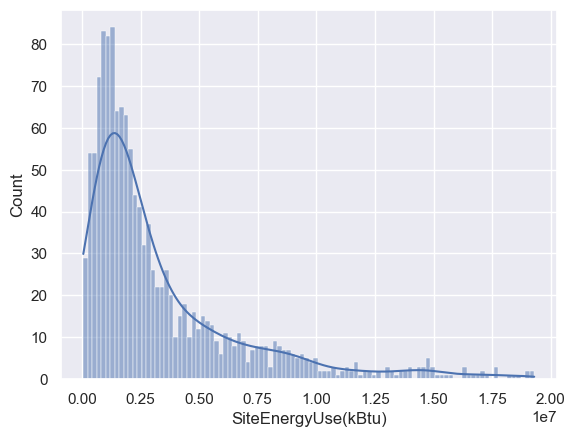

In [62]:
sns.histplot(data=building_df[(building_df['SiteEnergyUse(kBtu)'] < 2e7)],
             x='SiteEnergyUse(kBtu)', kde=True, bins=100)
plt.show()

- Distribution of TotalGHGEmissions (Emissions factor for electricity from Seattle City Light (2014): 20.08 lbs. CO2/MWh, emissions factor for steam from Enwave (2014): 170.17 lbs. CO2/MBtu, and emissions factor for gas (from Portfolio Manager): 53.11 kg CO2/MBtu):

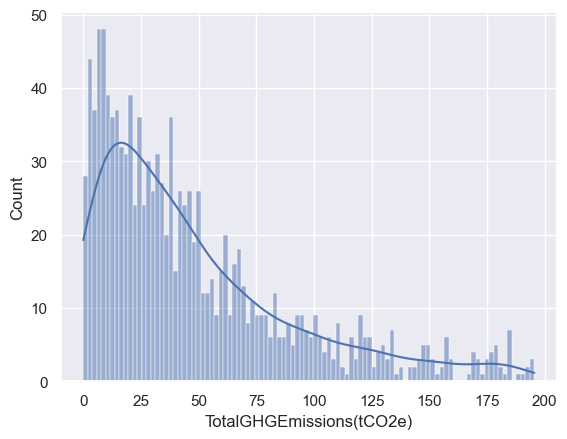

In [63]:
sns.histplot(data=building_df[(building_df['TotalGHGEmissions'] < 200)],
             x='TotalGHGEmissions', kde=True, bins=100)
plt.xlabel('TotalGHGEmissions(tCO2e)')
plt.show()

We see that both targets does not follow a normal distribution which can a problem for the linear regression models. We will test with and without log transformation of the target to check the error and score of the models.

- Correlation between the two tragets:

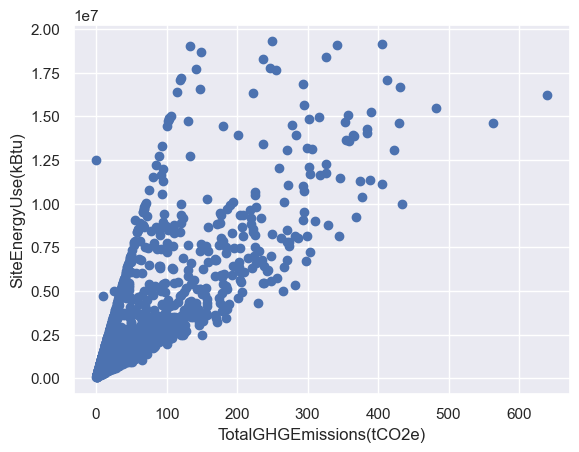

In [64]:
plt.plot(building_df['TotalGHGEmissions'], building_df['SiteEnergyUse(kBtu)'], 'o')
plt.ylabel('SiteEnergyUse(kBtu)')
plt.xlabel('TotalGHGEmissions(tCO2e)')
plt.show()

We see correlation between the two targets which is linked to the energy sources (electricity, steam and naturalGas).

### <font id='Sec.4.2'> B. Consumption of each source of energy

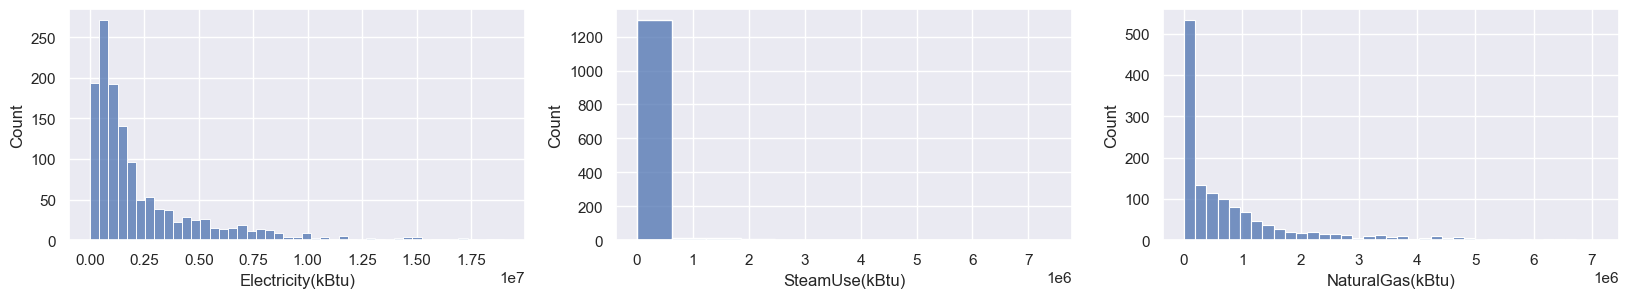

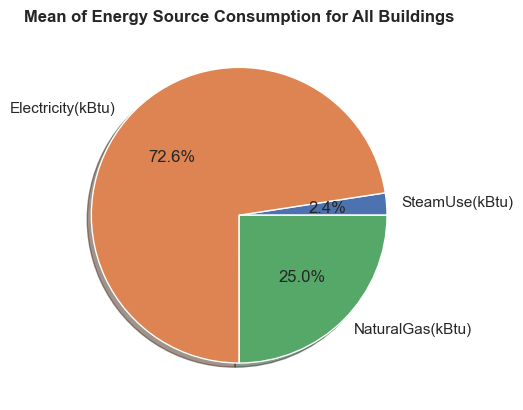

In [65]:
columns_list = ['Electricity(kBtu)','SteamUse(kBtu)','NaturalGas(kBtu)']
n_sub = len(columns_list)
n_col = 3
fig, axes = plt.subplots(int(round((0.49 + n_sub/n_col), 0)),
                         n_col, figsize=(20, int(1*n_sub)))
axes = np.array(axes)
i = 0
for ax in axes.reshape(-1):
    sns.histplot(data=building_df, x=columns_list[i], ax=ax)
    i += 1
plt.show()

plt.pie(building_df[['SteamUse(kBtu)', 'Electricity(kBtu)',
                     'NaturalGas(kBtu)']].mean(),
        labels=building_df[['SteamUse(kBtu)', 'Electricity(kBtu)',
                            'NaturalGas(kBtu)']].mean().index, 
        startangle=0, 
        shadow=True,
        autopct='%1.1f%%')
plt.title('Mean of Energy Source Consumption for All Buildings',
          fontsize=12, fontweight='bold')
plt.show()

Electricity, NaruralGas and Steam show skewed distribution. We see also dominance of Electricity over NaruralGas and Steam.

- Energy source Correlation with TotalGHGEmissions
    - Emissions factor for electricity from Seattle City Light (2014): 20.08 lbs. CO2/MWh
    - Emissions factor for steam from Enwave (2014): 170.17 lbs. CO2/MBtu
    - Emissions factor for gas (from Portfolio Manager): 53.11 kg CO2/MBtu

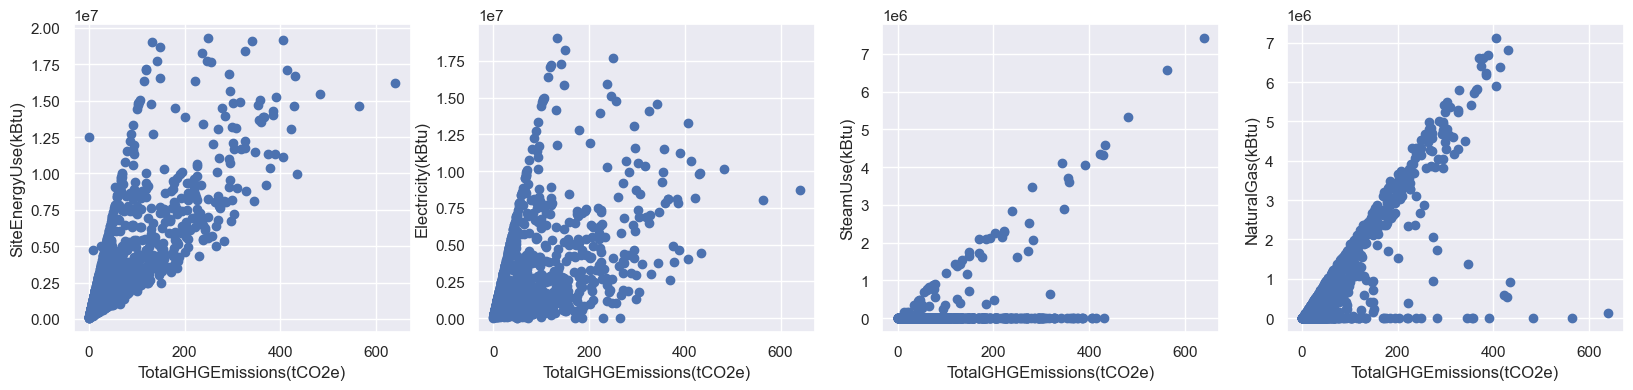

In [66]:
columns_list = ['SiteEnergyUse(kBtu)', 'Electricity(kBtu)',
                'SteamUse(kBtu)', 'NaturalGas(kBtu)']
n_sub = len(columns_list)
n_col = 4
fig, axes = plt.subplots(int(round((0.49 + n_sub/n_col), 0)),
                         n_col, figsize=(20, int(1*n_sub)))
axes = np.array(axes)
i = 0
for ax in axes.reshape(-1):
    ax.plot(building_df['TotalGHGEmissions'],
            building_df[columns_list[i]], 'o')
    ax.set_xlabel('TotalGHGEmissions(tCO2e)')
    ax.set_ylabel(columns_list[i])
    i += 1
plt.show()

Looking at the plots, we see different correlation values for each source of energy with TotalGHGEmissions as expected.

### <font id='Sec.4.3'> C. Efficiency of transmitting energy from source to site

In [67]:
print((building_df['SiteEUI(kBtu/sf)'] / building_df['SourceEUI(kBtu/sf)']).describe())

count    1330.000000
mean             inf
std              NaN
min         0.072889
25%         0.318780
50%         0.389706
75%         0.479677
max              inf
dtype: float64


**Not so efficient**, Seattle loose on average 60% of the energy due to transmitting from source to site.
- Dropping 'SourceEUI(kBtu/sf)' since we will not use it for the prediction.

In [68]:
building_df = building_df.drop(['SourceEUI(kBtu/sf)'], axis=1)

### <font id='Sec.4.4'> D. Distribution of the buildings on Seattle map
- Checking if there are effect of building location on SiteEnergyUse(kBtu)

In [69]:
colormap = cm.LinearColormap(colors=['green', 'orange', 'red'], vmin=0,
                             vmax=building_df['SiteEnergyUse(kBtu)'].median()*5)
Seattle_Map = folium.Map(location=[building_df['Latitude'].mean(),
                                   building_df['Longitude'].mean()], zoom_start=11)

lat = list(building_df['Latitude'])
lon = list(building_df['Longitude'])
color_pow = list(building_df['SiteEnergyUse(kBtu)'])

for loc, p in zip(zip(building_df.Latitude, building_df.Longitude), color_pow):
    folium.Circle(location=loc, radius=5, color=colormap(p)).add_to(Seattle_Map)
            
Seattle_Map.add_child(colormap)
Seattle_Map

We see **no effect** of location on the energy usage of the building.
- Checking if there are effect of building location on TotalGHGEmissions

In [70]:
colormap = cm.LinearColormap(colors=['green', 'orange', 'red'], vmin=0,
                             vmax=building_df['TotalGHGEmissions'].median()*5)
Seattle_Map = folium.Map(location=[building_df['Latitude'].mean(),
                                   building_df['Longitude'].mean()], zoom_start=11)

lat = list(building_df['Latitude'])
lon = list(building_df['Longitude'])
color_pow = list(building_df['TotalGHGEmissions'])

for loc, p in zip(zip(building_df.Latitude, building_df.Longitude), color_pow):
    folium.Circle(location=loc, radius=5, color=colormap(p)).add_to(Seattle_Map)
            
Seattle_Map.add_child(colormap)
Seattle_Map

Similar to SiteEnergyUse, we see **no effect** of the building location on the GHG emission.
- Dropping latitude and longitude columns from the database.

In [71]:
building_df = building_df.drop(['Latitude', 'Longitude'], axis=1)

### <font id='Sec.4.5'> E. GFA distribution

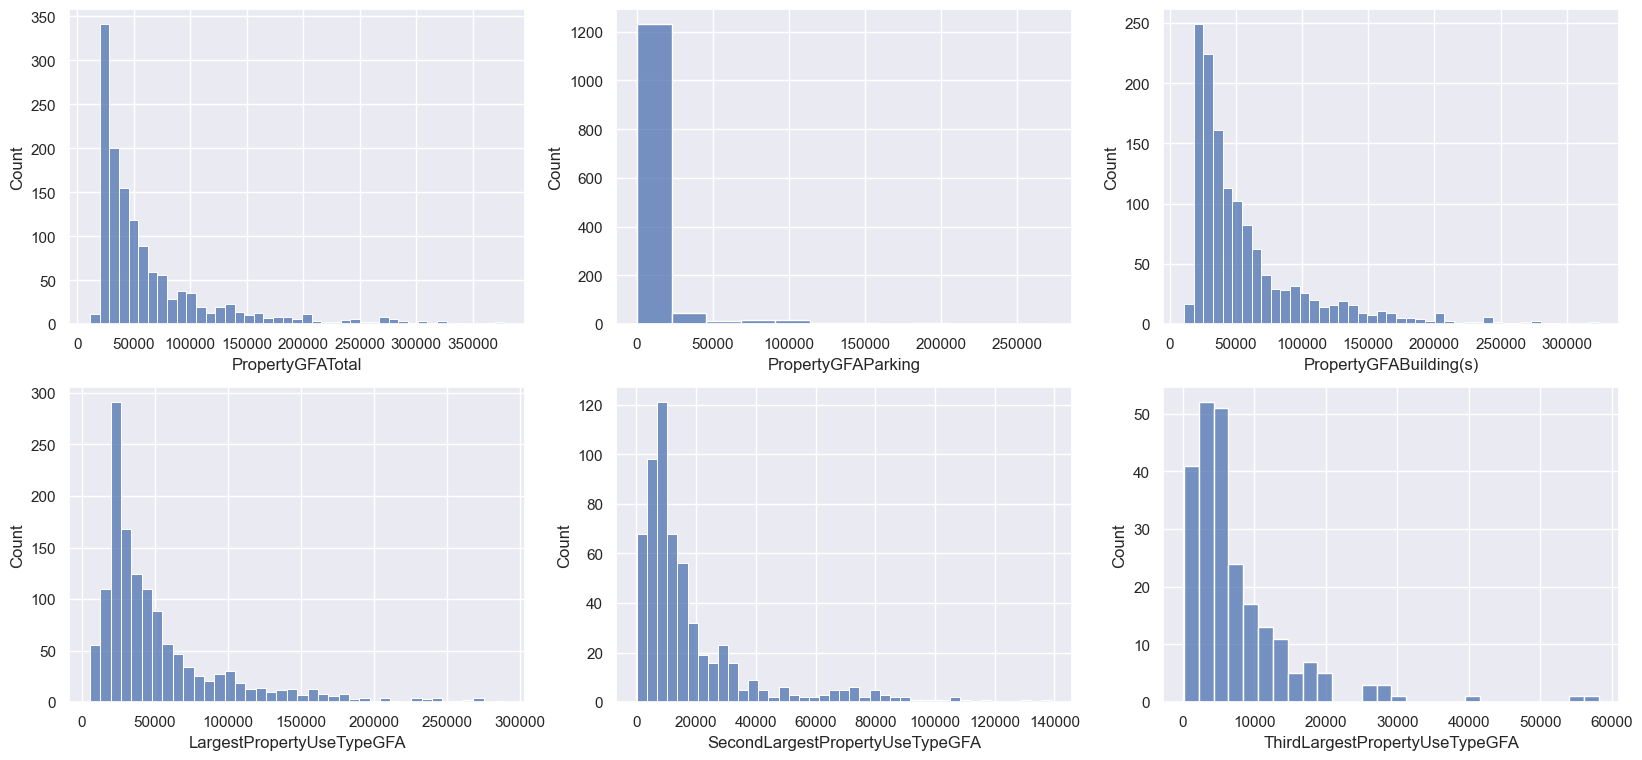

In [72]:
columns_list = ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA']
n_sub = len(columns_list)
n_col = 3
fig, axes = plt.subplots(int(round((0.49 + n_sub/n_col), 0)),
                         n_col, figsize=(20, int(1.5*n_sub)))
axes = np.array(axes)
i = 0
for ax in axes.reshape(-1):
    sns.histplot(data=building_df, x=columns_list[i], ax=ax)
    i += 1
plt.show()

We see that all distributions are skewed, we will use PowerTransformer as an option to log scale the distribution before the ML prediction.
- Correlation between SiteEnergyUse(kBtu) with all other GFA columns:

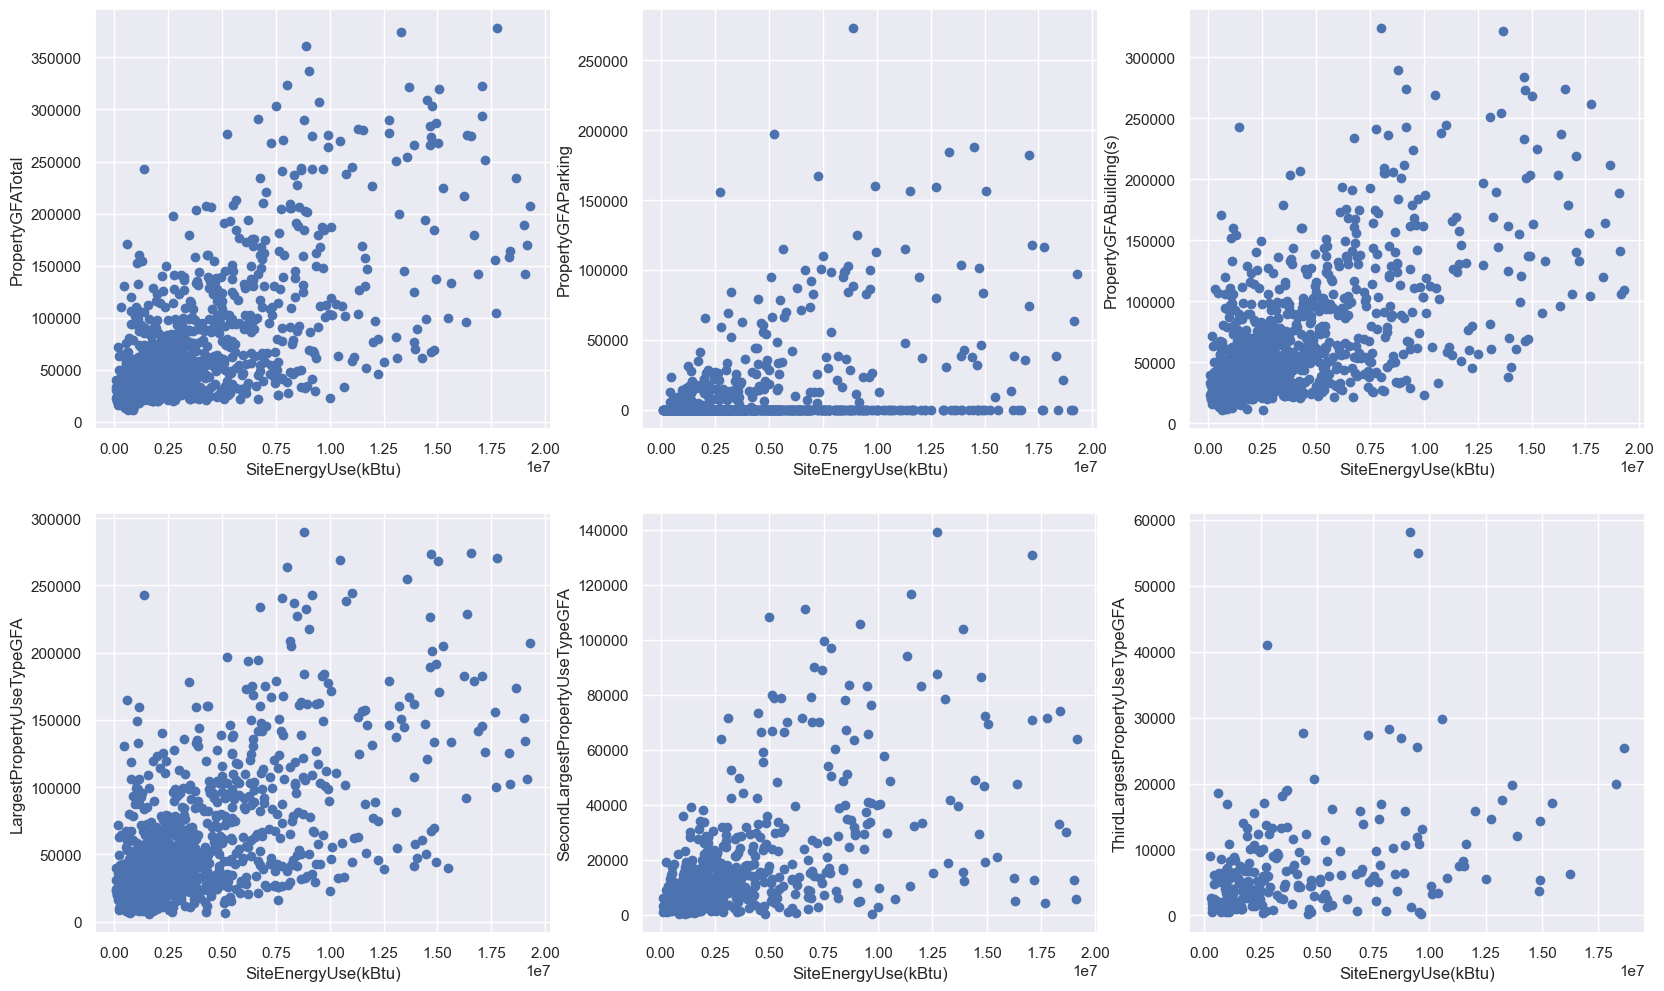

In [73]:
columns_list = ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA']
n_sub = len(columns_list)
n_col = 3
fig, axes = plt.subplots(int(round((0.49 + n_sub/n_col), 0)),
                         n_col, figsize=(20, int(2*n_sub)))
axes = np.array(axes)
i = 0
for ax in axes.reshape(-1):
    ax.plot(building_df['SiteEnergyUse(kBtu)'],
            building_df[columns_list[i]], 'o')
    ax.set_xlabel('SiteEnergyUse(kBtu)')
    ax.set_ylabel(columns_list[i])
    i += 1
plt.show()

We see correlation between GFA columns with SiteEnergyUse. The bigger the GFA of the building the larger the energy consumption.

- Correlation between TotalGHGEmissions with all other GFA columns:

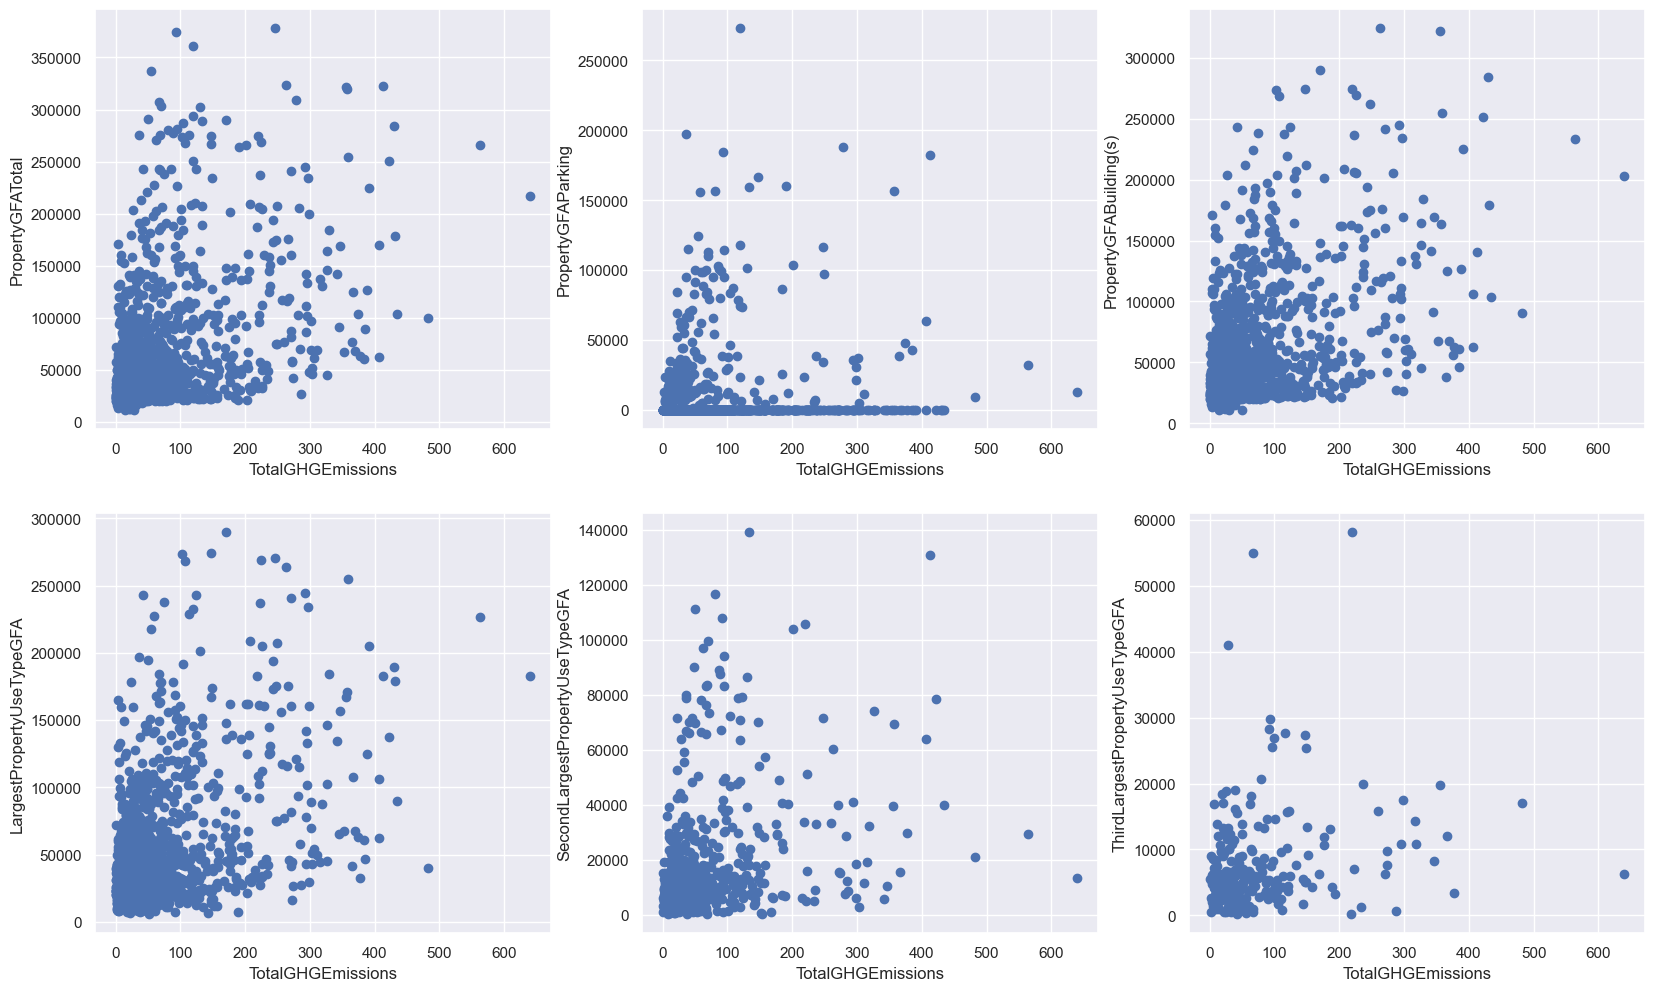

In [74]:
columns_list = ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA']
n_sub = len(columns_list)
n_col = 3
fig, axes = plt.subplots(int(round((0.49 + n_sub/n_col), 0)),
                         n_col, figsize=(20, int(2*n_sub)))
axes = np.array(axes)
i = 0
for ax in axes.reshape(-1):
    ax.plot(building_df['TotalGHGEmissions'],
            building_df[columns_list[i]], 'o')
    ax.set_xlabel('TotalGHGEmissions')
    ax.set_ylabel(columns_list[i])
    i += 1
plt.show()

We see correlation between GFA columns with TotalGHGEmissions as well. The bigger the GFA of the building the higher the GHG emissions.

### <font id='Sec.4.6'> F. Distribution of building age and building decade

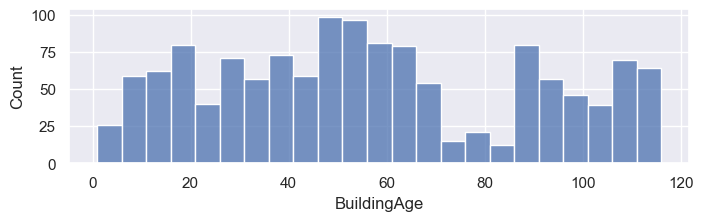

In [75]:
plt.figure(figsize=(8, 2))
sns.histplot(data=building_df.sort_values('BuildingAge'), x='BuildingAge', binwidth=5)
plt.show()

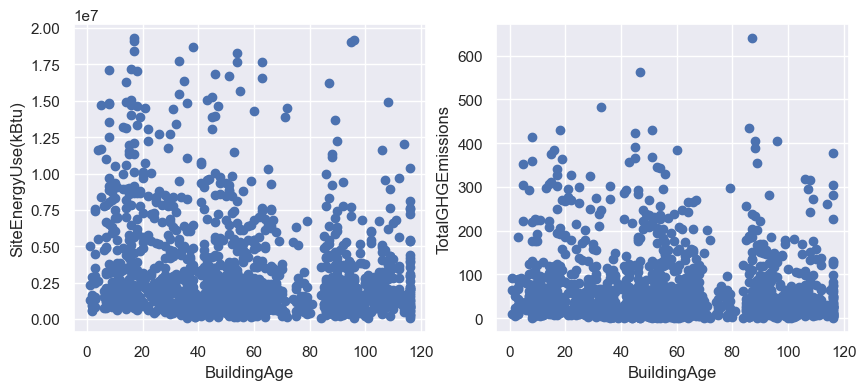

In [76]:
columns_list = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
n_sub = len(columns_list)
n_col = 2
fig, axes = plt.subplots(int(round((0.49 + n_sub/n_col), 0)),
                         n_col, figsize=(10, int(2*n_sub)))
axes = np.array(axes)
i = 0
for ax in axes.reshape(-1):
    ax.plot(building_df['BuildingAge'],
            building_df[columns_list[i]], 'o')
    ax.set_xlabel('BuildingAge')
    ax.set_ylabel(columns_list[i])
    i += 1
plt.show()

**No much correlation** of the building age with SiteEnergyUse(kBtu) and TotalGHGEmissions.

We will check building Decade since it's much easier to see small effect using building Decade over age. 

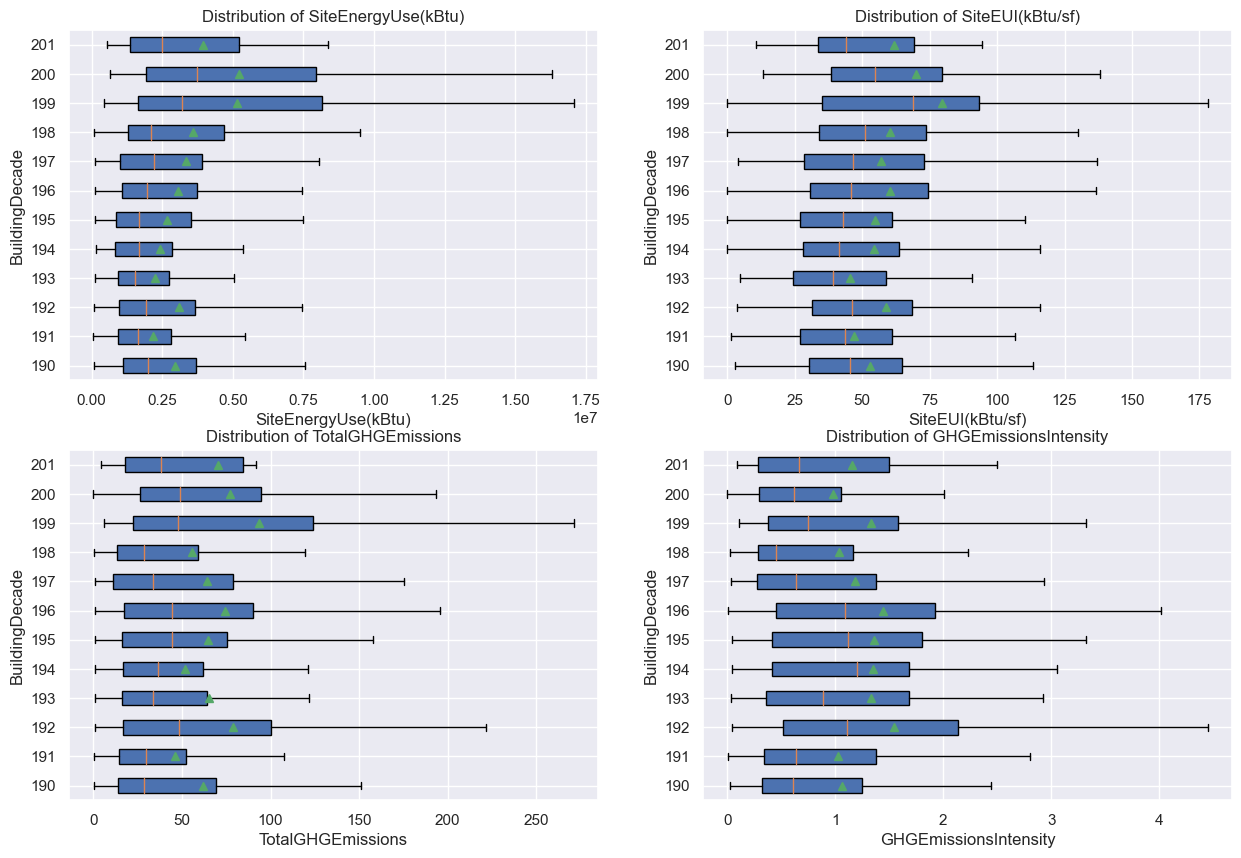

In [77]:
columns_list=['SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)',
              'TotalGHGEmissions', 'GHGEmissionsIntensity']
n_sub = len(columns_list)
n_col = 2
fig, axes = plt.subplots(int(round((0.49+n_sub/n_col), 0)),
                         n_col, figsize=(15, int(2.5*n_sub)))
axes = np.array(axes)
i = 0
BuildingDecade_list = building_df.groupby(by='BuildingDecade').nunique().sort_values('BuildingDecade',
                                                                                     ascending=True).index
for ax in axes.reshape(-1):   
    groupes = []
    for m in BuildingDecade_list:
        groupes.append(building_df[building_df['BuildingDecade'] == m][columns_list[i]])
    ax.boxplot(groupes, labels=BuildingDecade_list, showfliers=False, 
               vert=False, patch_artist=True, showmeans=True)
    ax.set_title('Distribution of {}'.format(columns_list[i]))
    ax.set_xlabel(format(columns_list[i]))
    ax.set_ylabel(format('BuildingDecade'))
    i += 1
plt.show()

**Small correlation** of the building Decade with SiteEnergyUse(kBtu) but not with TotalGHGEmissions. However looking at the energy usage intensity column SiteEUI, the correlation disappear meaning that bigger GFA are built now a day than in the past which explain the higher energy usage of newer buildings. Thus the correlation of age is more linked to GFA.

### <font id='Sec.4.7'> G. ENERGYSTARScore distribution
ENERGY STAR score is a metric that compares a building’s energy use to other U.S. buildings on a scale from 1 to 100, where 1 is least efficient and 100 is most efficient.

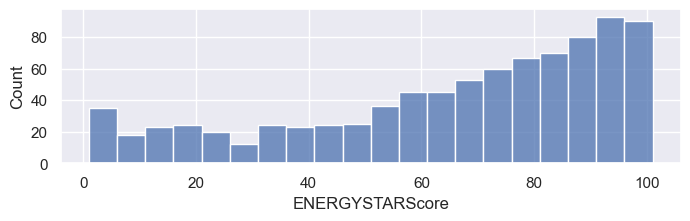

In [78]:
plt.figure(figsize=(8, 2))
sns.histplot(data=building_df.sort_values('ENERGYSTARScore'),
             x='ENERGYSTARScore', binwidth=5)
plt.show()

We see that the majority of buildings in Seattle are energy efficient.

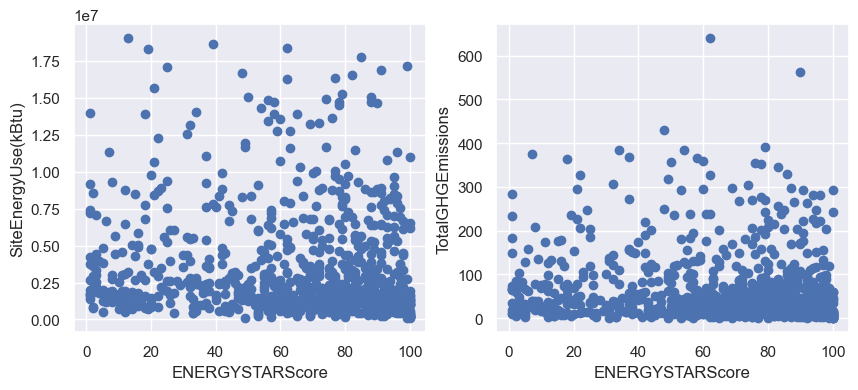

In [79]:
columns_list = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
n_sub = len(columns_list)
n_col = 2
fig, axes = plt.subplots(int(round((0.49 + n_sub/n_col), 0)),
                         n_col, figsize=(10, int(2*n_sub)))
axes = np.array(axes)
i = 0
for ax in axes.reshape(-1):
    ax.plot(building_df['ENERGYSTARScore'],
            building_df[columns_list[i]], 'o')
    ax.set_xlabel('ENERGYSTARScore')
    ax.set_ylabel(columns_list[i])
    i += 1
plt.show()

**Low correlation** of the ENERGYSTARScore with SiteEnergyUse(kBtu) and TotalGHGEmissions.

### <font id='Sec.4.8'> H. NumberofBuildings and NumberofFloors distribution

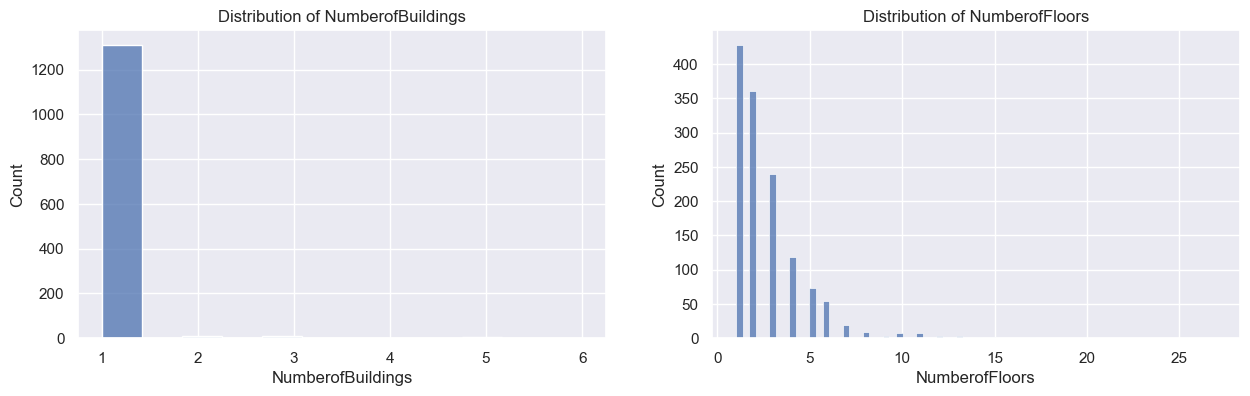

In [80]:
columns_list = ['NumberofBuildings', 'NumberofFloors']
n_sub = len(columns_list)
n_col = 2
fig, axes = plt.subplots(int(round((0.49+n_sub/n_col), 0)),
                         n_col, figsize=(15, int(2*n_sub)))
axes = np.array(axes)
i = 0
for ax in axes.reshape(-1):
    sns.histplot(data=building_df[columns_list[i]], ax=ax)
    ax.set_title('Distribution of {}'.format(columns_list[i]))
    i += 1
plt.show()

NumberofBuildings is mostly 1, we will not use it for the prediction.

We check the correlation of number of Floors with SiteEnergyUse and TotalGHGEmissions:

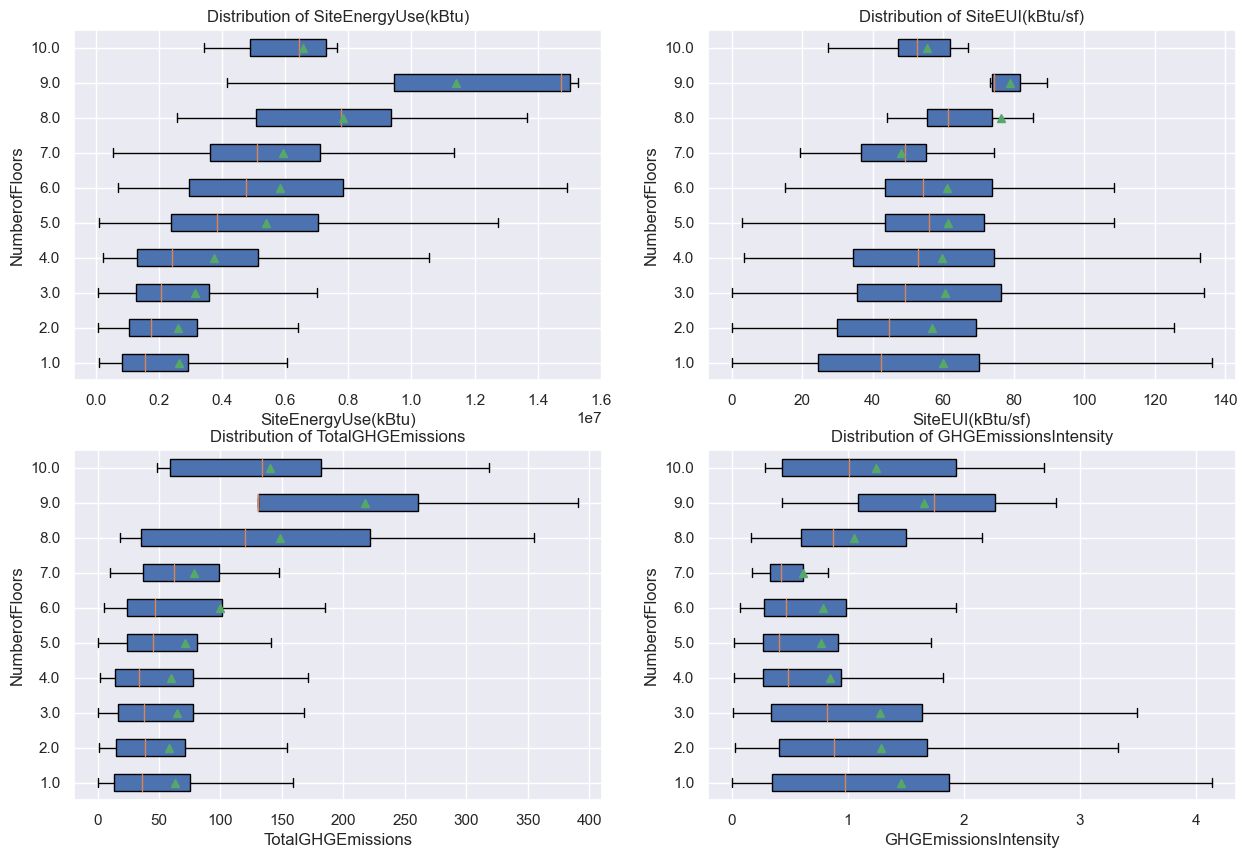

In [81]:
columns_list=['SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)',
              'TotalGHGEmissions', 'GHGEmissionsIntensity']
n_sub = len(columns_list)
n_col = 2
fig, axes = plt.subplots(int(round((0.49+n_sub/n_col), 0)),
                         n_col, figsize=(15, int(2.5*n_sub)))
axes = np.array(axes)
i = 0
BuildingDecade_list = building_df.groupby(by='NumberofFloors').nunique().head(10).sort_values('NumberofFloors',
                                                                                              ascending=True).index
for ax in axes.reshape(-1):   
    groupes = []
    for m in BuildingDecade_list:
        groupes.append(building_df[building_df['NumberofFloors'] == m][columns_list[i]])
    ax.boxplot(groupes, labels=BuildingDecade_list, showfliers=False, 
               vert=False, patch_artist=True, showmeans=True)
    ax.set_title('Distribution of {}'.format(columns_list[i]))
    ax.set_xlabel(format(columns_list[i]))
    ax.set_ylabel(format('NumberofFloors'))
    i += 1
plt.show()

Similar observation to BuildingDecade, the NumberofFloors show correlation with SiteEnergyUse(kBtu), TotalGHGEmissions but not to SiteEUI(kBtu/sf) and GHGEmissionsIntensity is due to the direct link of GFA with the number of floors in the building.

### <font id='Sec.4.9'> I. Correlation between all numerical columns

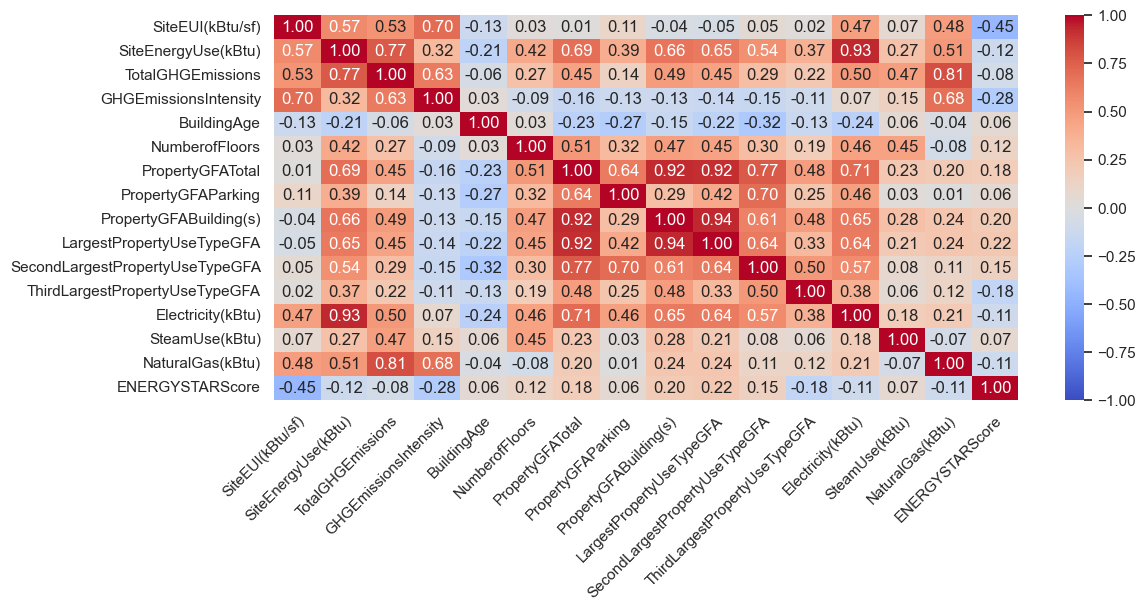

In [82]:
columns_list=['SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
              'GHGEmissionsIntensity', 'BuildingAge', 'NumberofFloors',
              'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
              'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
              'ThirdLargestPropertyUseTypeGFA', 'Electricity(kBtu)',
              'SteamUse(kBtu)', 'NaturalGas(kBtu)', 'ENERGYSTARScore']
plt.figure(figsize=(12, 5))
sns.heatmap(building_df[columns_list].corr(method='pearson'),
            vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='0.2f')
plt.xticks(ha='right', rotation=45, rotation_mode='anchor')
plt.show()

Final conclusion on numerical columns:
- We see high correlation of SiteEnergyUse with PropertyGFATotal, PropertyGFABuilding, LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, SiteEUI, Electricity, NaturalGas, TotalGHGEmissions.
    - For number of Floors, we see again a significant correlation with SiteEnergyUse and GFA informations but not with SiteEUI. We will keep it for now and test it on the final model to check if the score is better with or without number of Floors.
    - BuildingAge show small correlation with SiteEnergyUse as discussed before. We will keep it for now and test it on the final model to check if the score is better with or without BuildingAge.
    - There is significant negative correlation of ENERGYSTARScore with SiteEnergyUse. As noted in the project, we will check the score of the final model with and without ENERGYSTARScore.
    - Because there is lot of missing values in SecondLargestPropertyUseTypeGFA and ThirdLargestPropertyUseTypeGFA, we will use instead the newly created columns ending with _GFAratio which combine the informations in LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA and ThirdLargestPropertyUseTypeGFA with their PropertyUseType.
    - For the model prediction of SiteEnergyUse, the numerical columns that will be used: PropertyGFATotal, PropertyGFABuilding, and (LargestPropertyUseTypeGFA or all columns ending with _GFAratio). SiteEUI, Electricity, NaturalGas, and TotalGHGEmissions columns are not selected because they relate to energy consumption informations which will not be known for new buildings.
    
- We see high correlation of TotalGHGEmissions with PropertyGFATotal, PropertyGFABuilding, LargestPropertyUseTypeGFA, SiteEUI, SiteEnergyUse, Steam, Electricity, NaturalGas, GHGEmissionsIntensity, and EnergySourceCounts.
    - We see small correlation of number of Floors with TotalGHGEmissions but not with GHGEmissionsIntensity which is due to the direct correlation of number of Floors with GFA informations as discussed before. We will keep it for now and test it on the final model to check if the score is better with or without number of Floors.
    - Again, we see unsigificant correlation of TotalGHGEmissions with BuildingAge as discussed before. We will keep it for now and test it on the final model to check if the score is better with or without BuildingAge.
    - There is unsignificant correlation of ENERGYSTARScore with TotalGHGEmissions. As noted in the project, we will check the score of the final model with and without ENERGYSTARScore.
    - For the model prediction of TotalGHGEmissions, the numerical columns that will be used: PropertyGFATotal, PropertyGFABuilding, EnergySourceCounts, and (LargestPropertyUseTypeGFA or all columns ending with _GFAratio). SiteEUI, SiteEnergyUse, Steam, Electricity, NaturalGas, and GHGEmissionsIntensity columns are not selected because they relate to energy consumption informations which will not be known for new buildings.
    
    
- For the categorical columns, they will be analysed and selected below.

### <font id='Sec.4.10'> J. Correlation of each categorical columns with SiteEUI(kBtu/sf), SiteEnergyUse(kBtu), TotalGHGEmissions, and GHGEmissionsIntensity

- Distribution of SiteEUI(kBtu/sf), SiteEnergyUse(kBtu), TotalGHGEmissions, and GHGEmissionsIntensity for each categorical columns

In [83]:
# Function that plot the distributions of some numerical columns for each categorcical columns
def distribution_of_num_for_each_categ(df, columns_list, cat_columns):
    n_sub = len(columns_list)
    n_col = 2
    for cat_column in cat_columns:
        fig, axes = plt.subplots(int(round((0.49+n_sub/n_col), 0)),
                                 n_col, figsize=(20, int(2*n_sub)))
        axes = np.array(axes)
        i = 0
        top_BuildingType_list = df.groupby(by=cat_column).nunique().sort_values('OSEBuildingID',
                                                                                ascending=False).head(10).index
        for ax in axes.reshape(-1):   
            groupes = []
            for m in top_BuildingType_list:
                groupes.append(df[df[cat_column] == m][columns_list[i]])
            ax.boxplot(groupes, labels=top_BuildingType_list, showfliers=False, 
                       vert=False, patch_artist=True, showmeans=True)
            ax.set_title('Distribution of {}'.format(columns_list[i]))
            ax.set_xlabel(format(columns_list[i]))
            if i%n_col == 0:
                ax.set_ylabel(format(cat_column))
            i += 1
        plt.show()

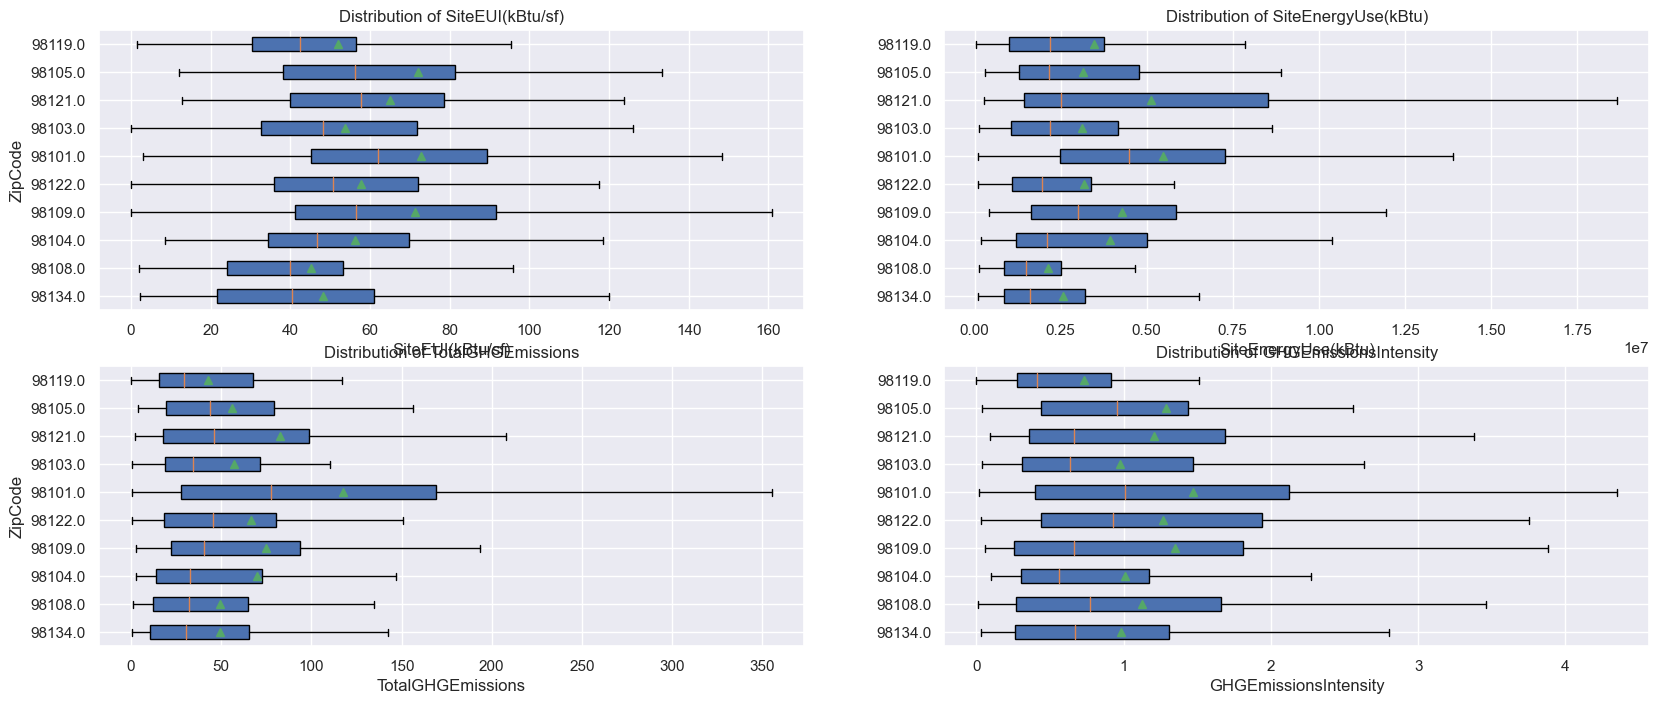

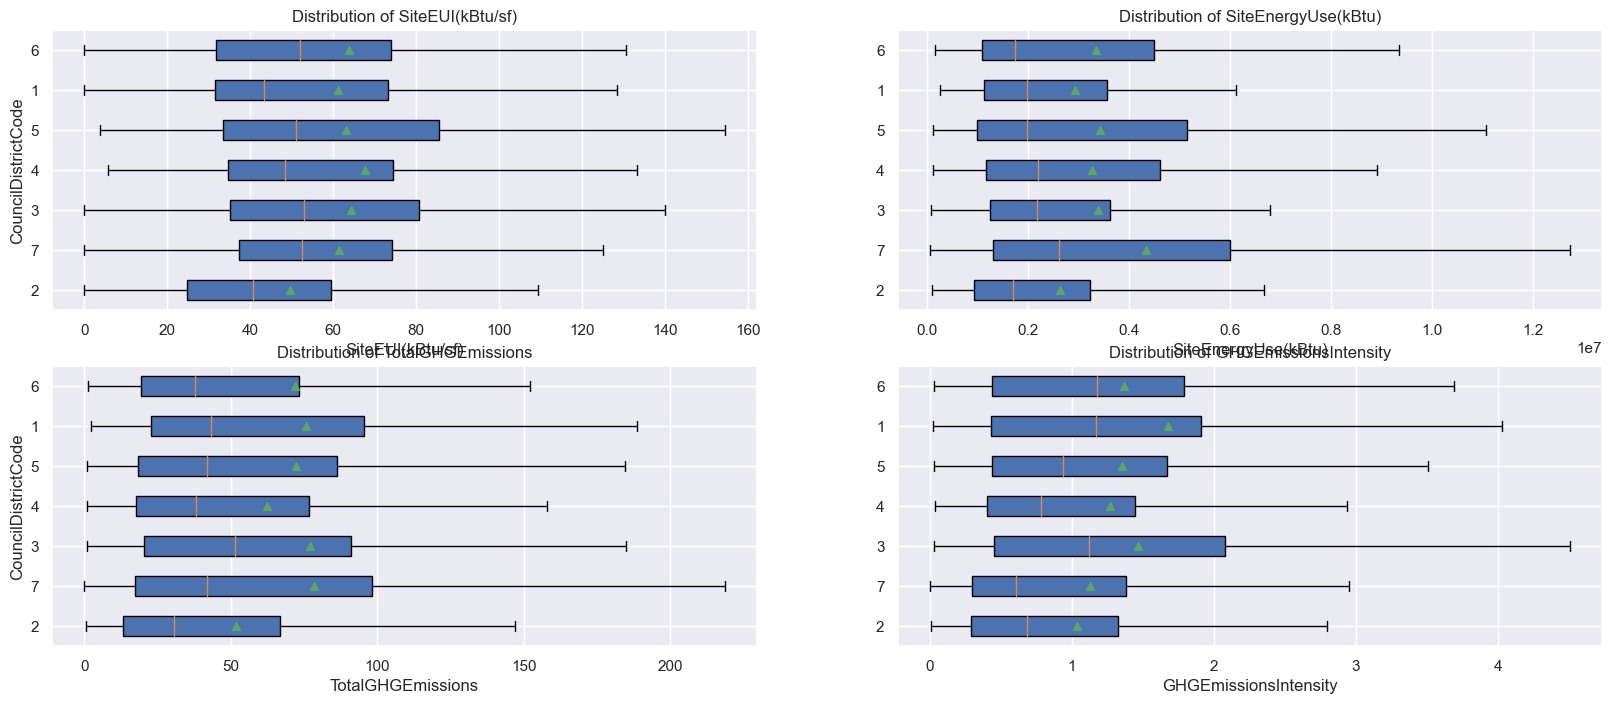

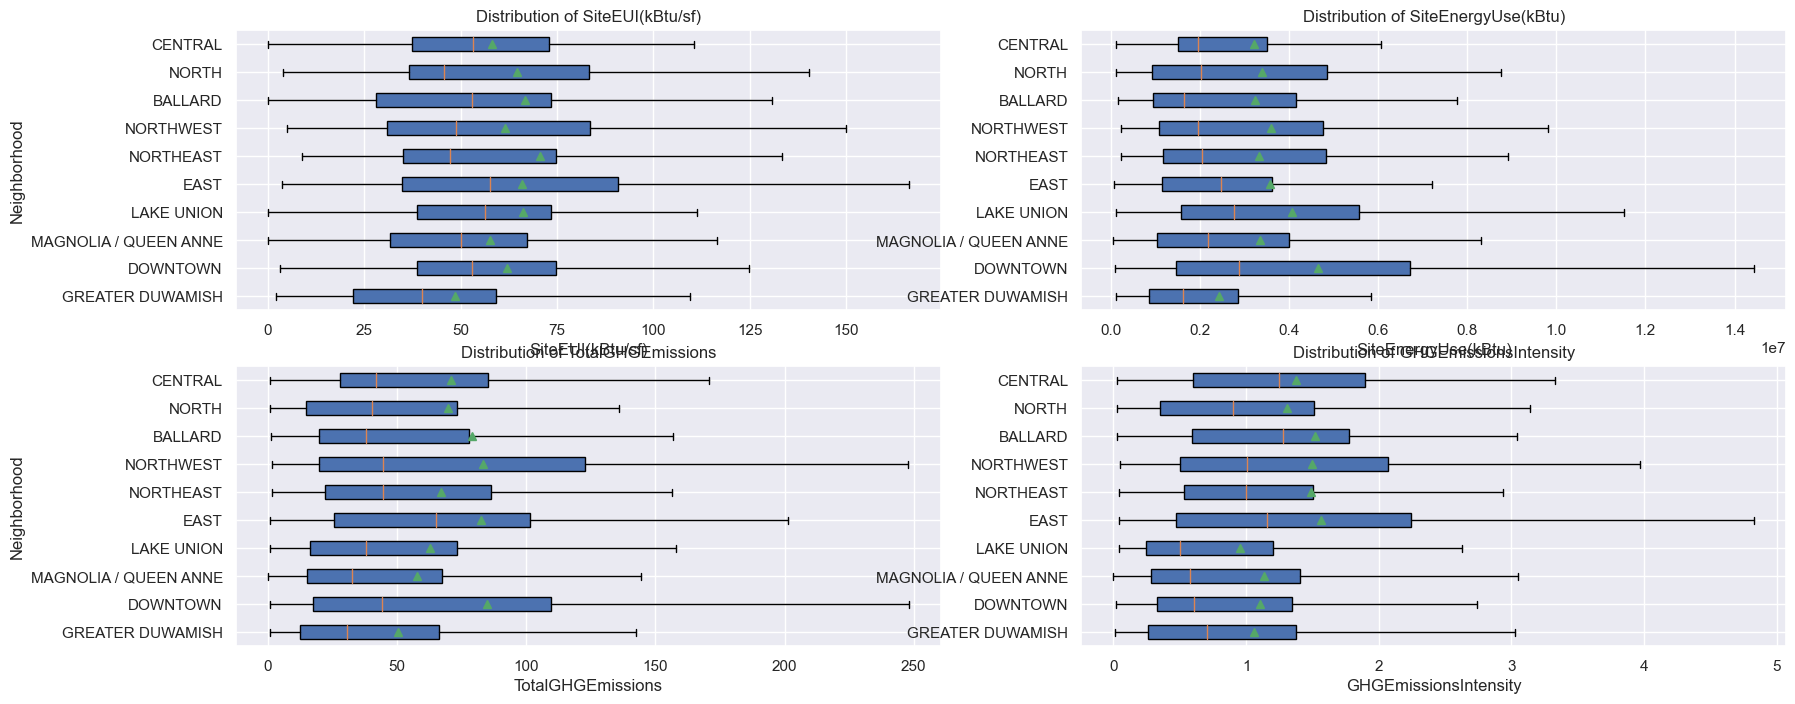

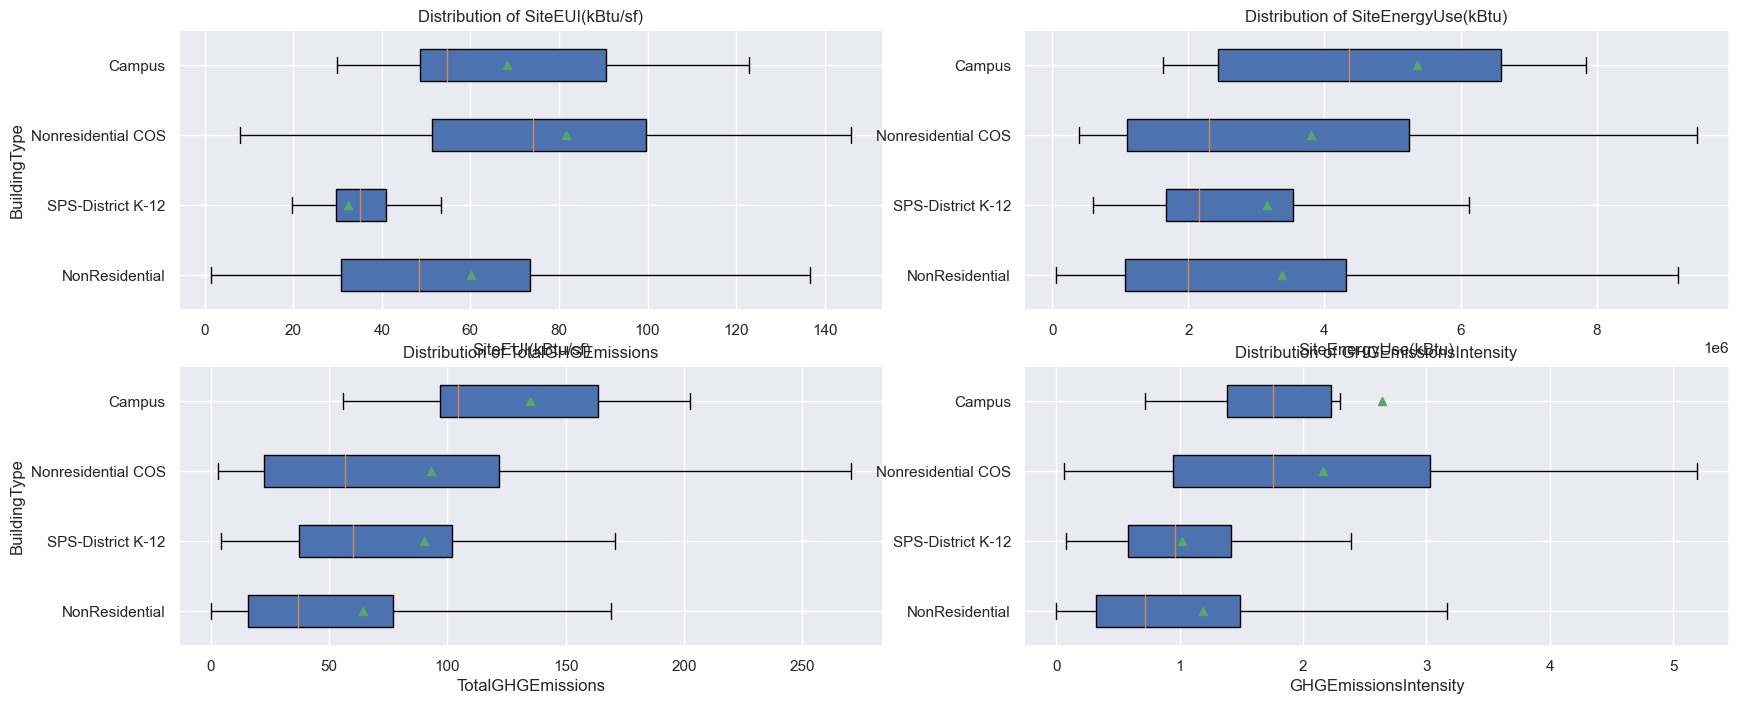

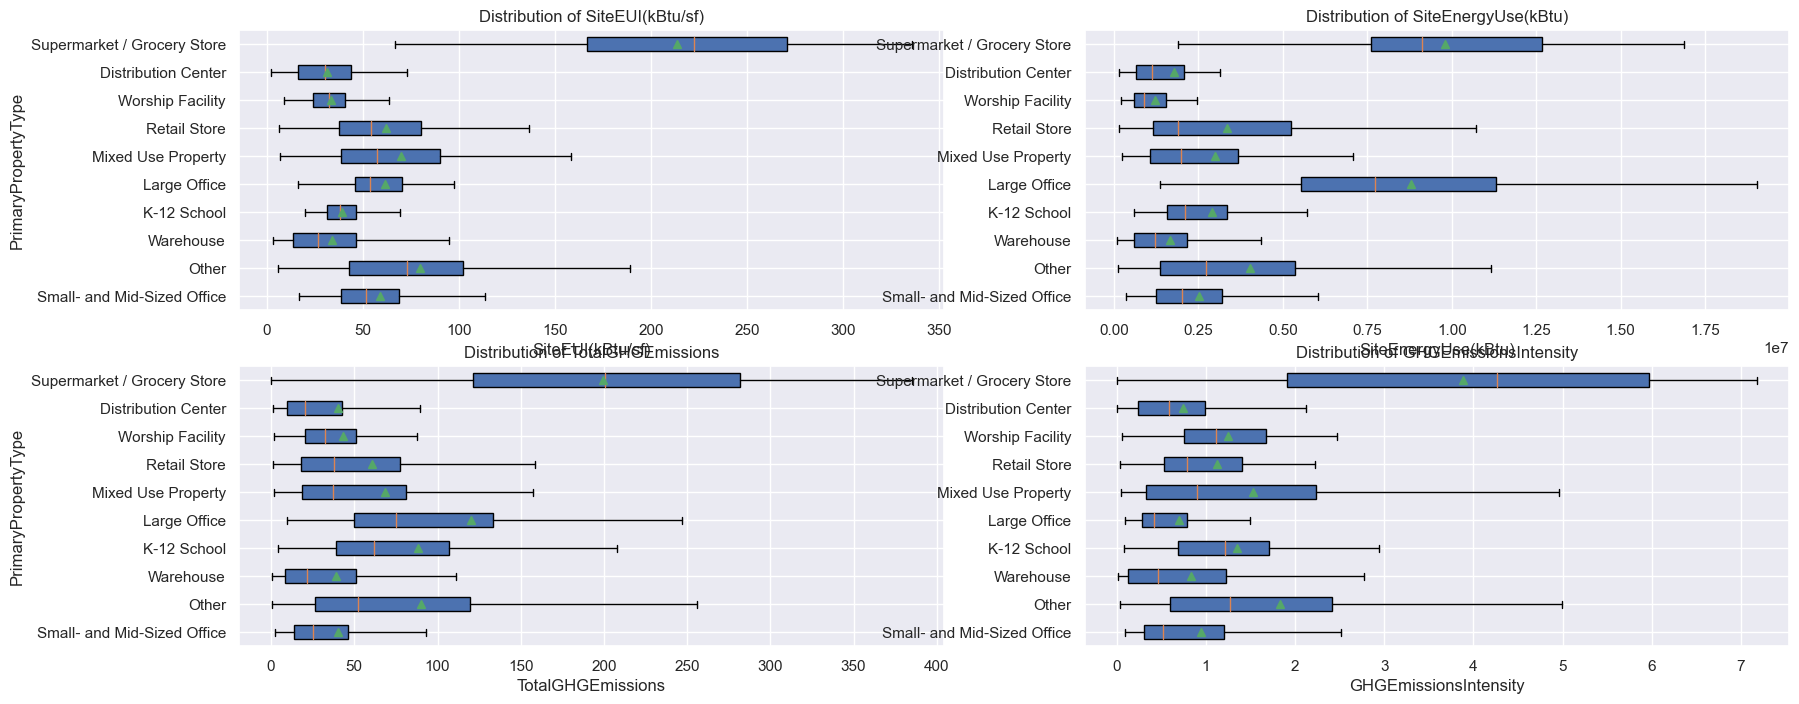

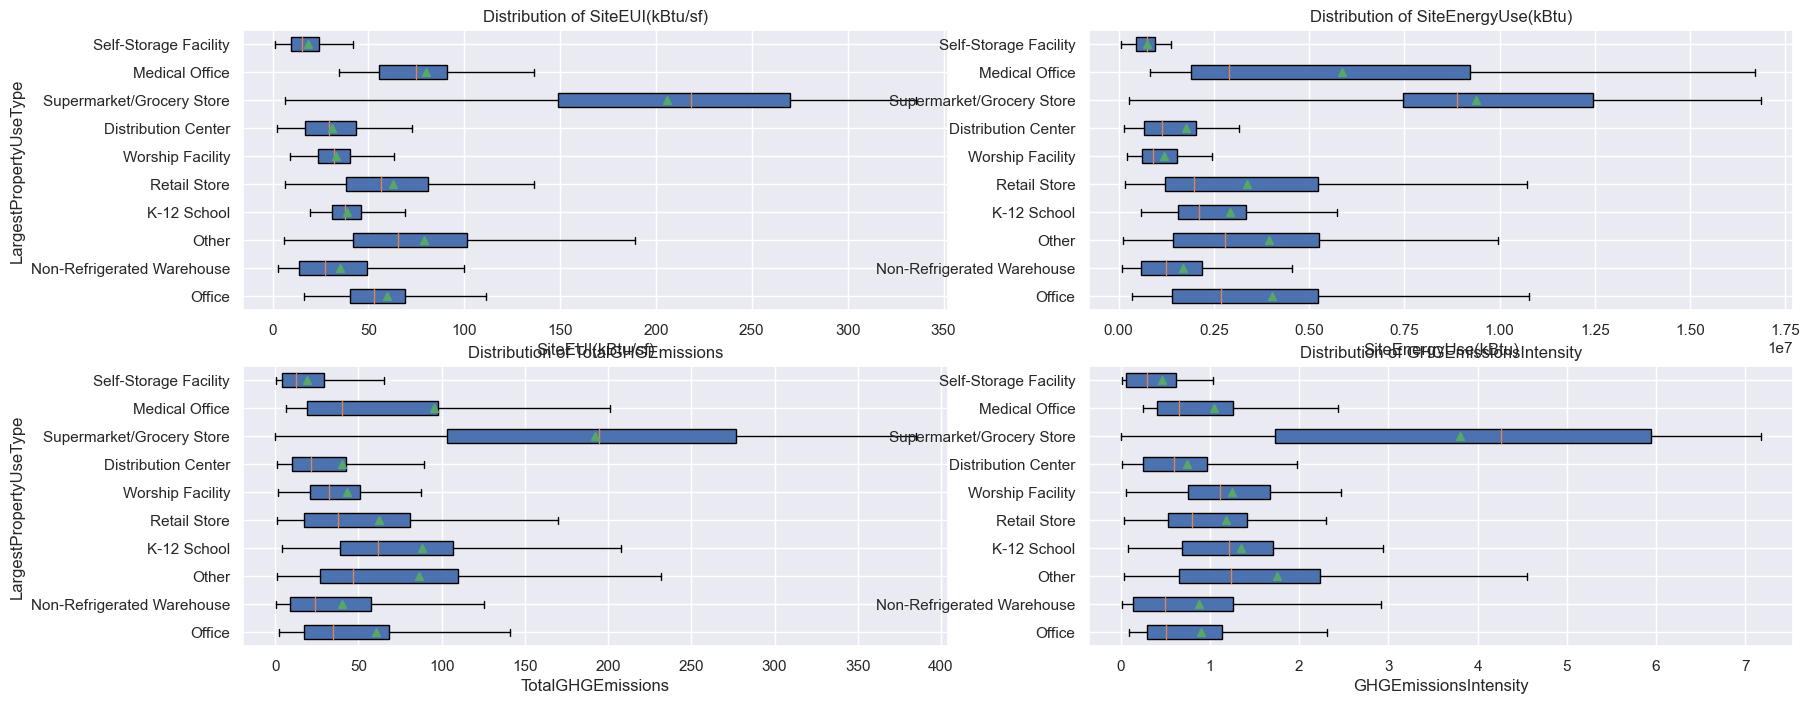

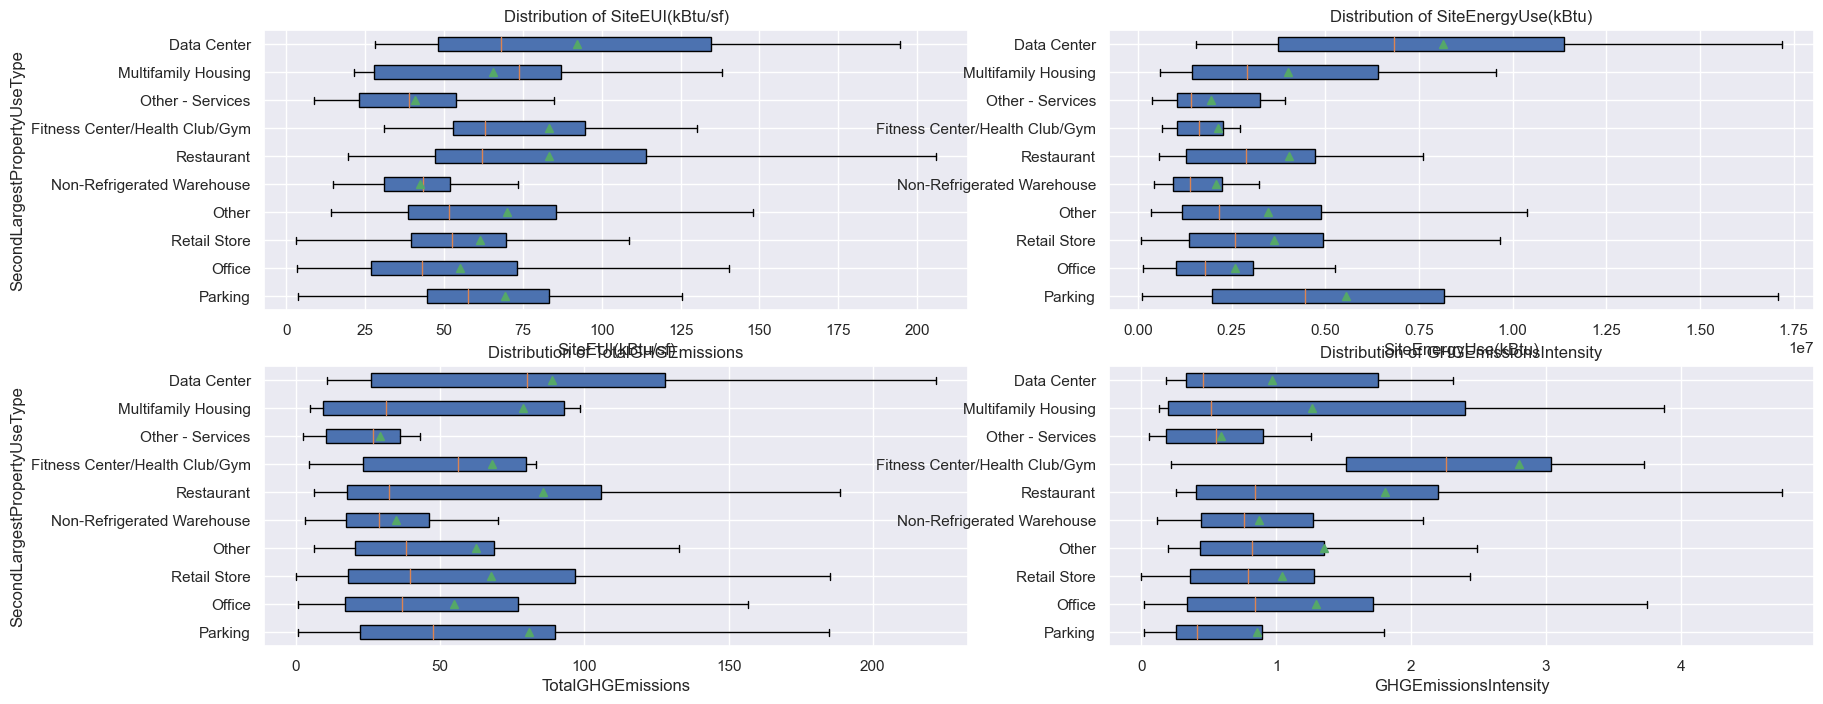

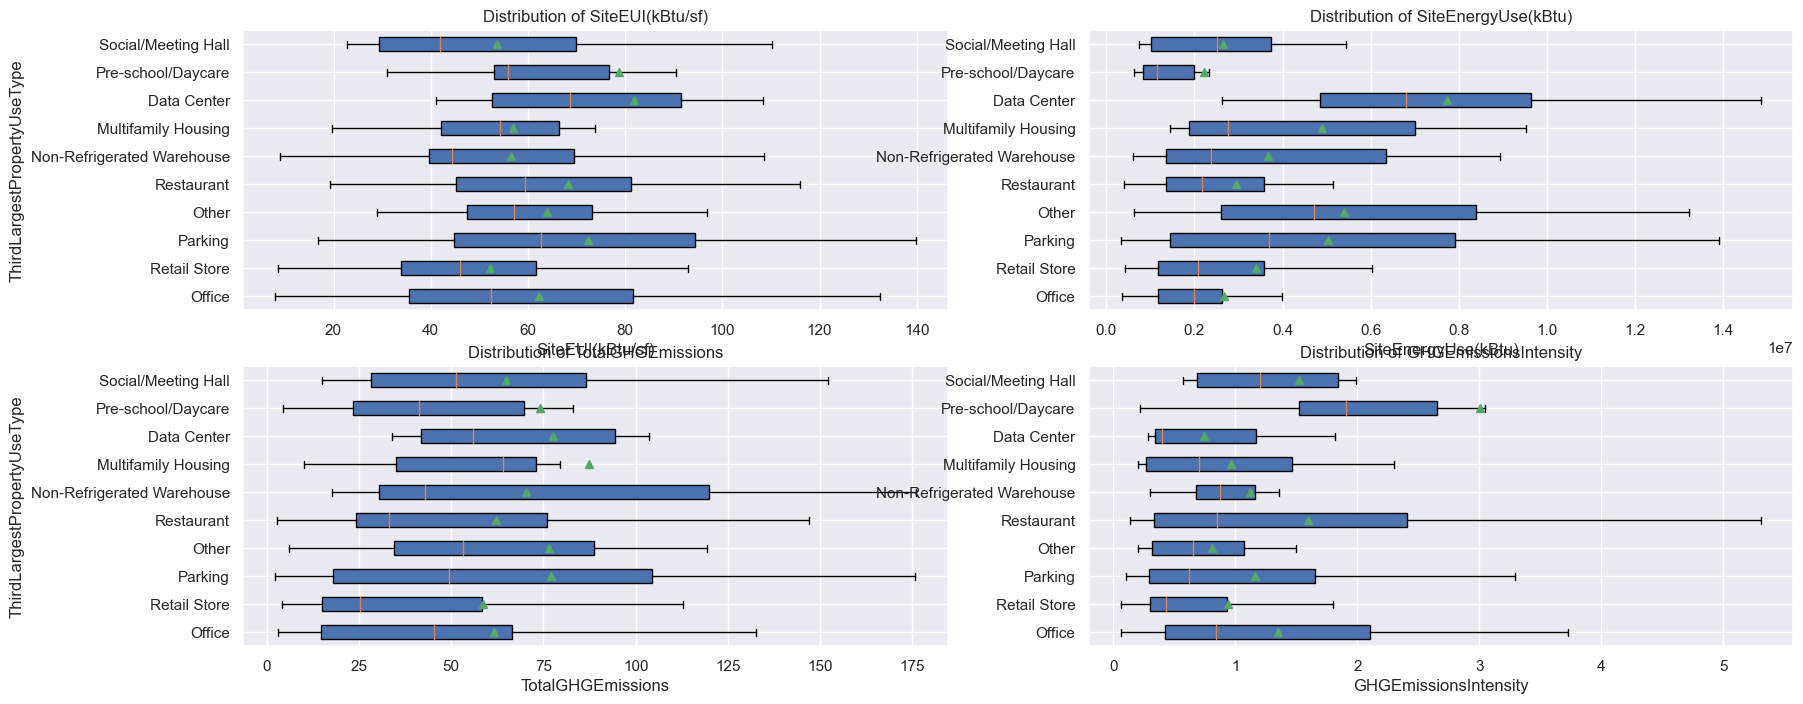

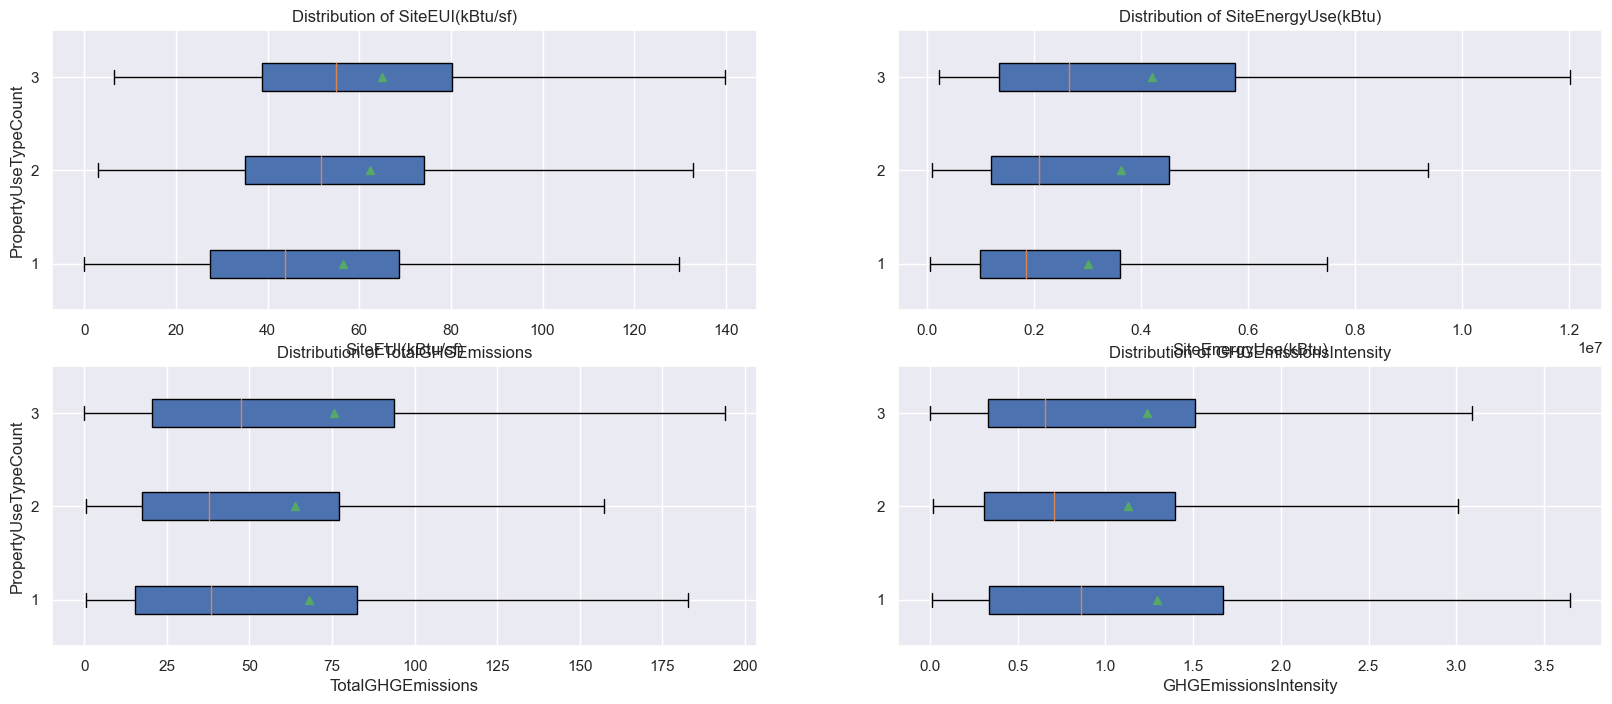

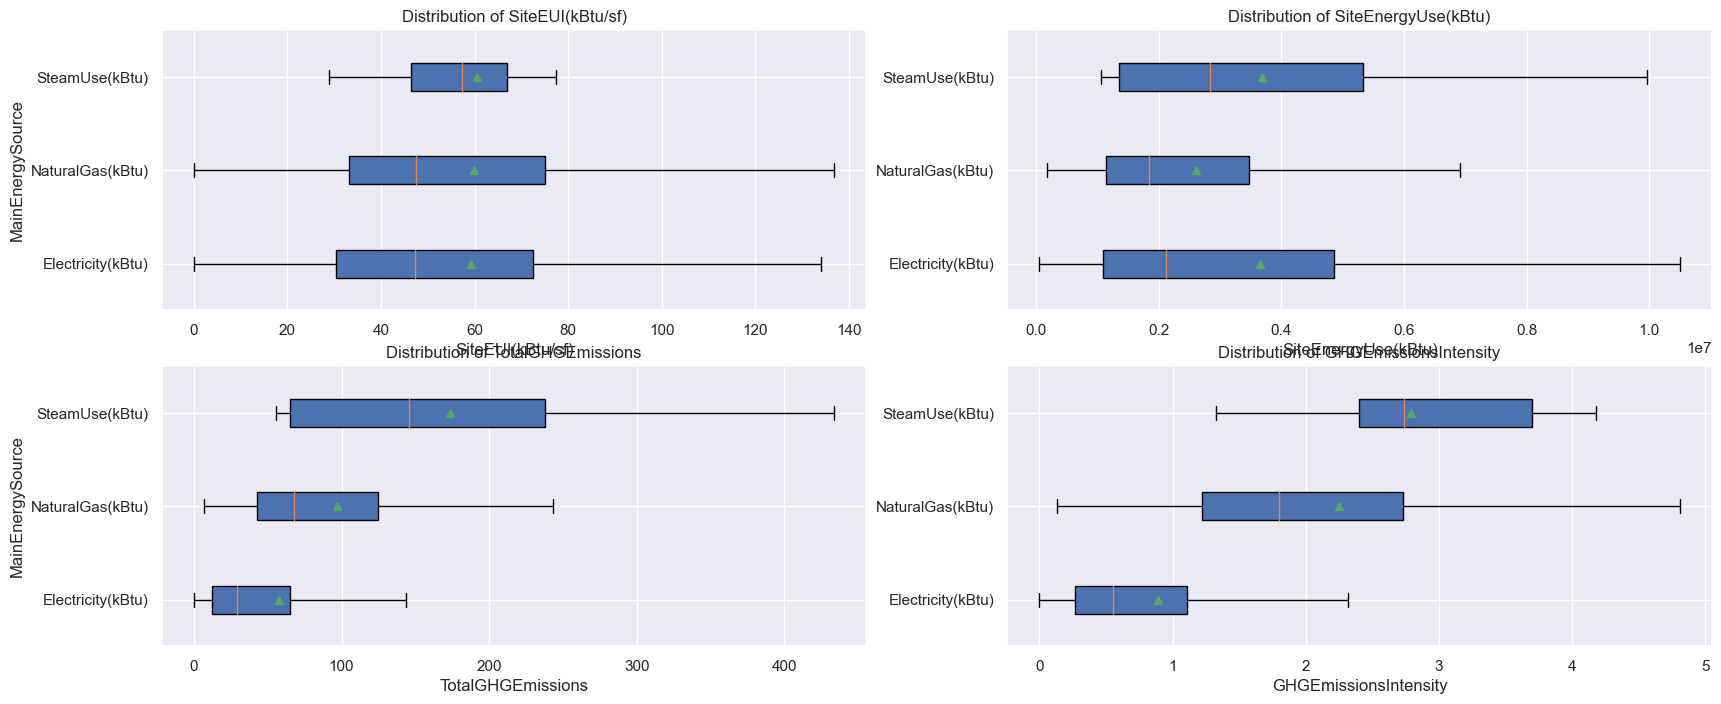

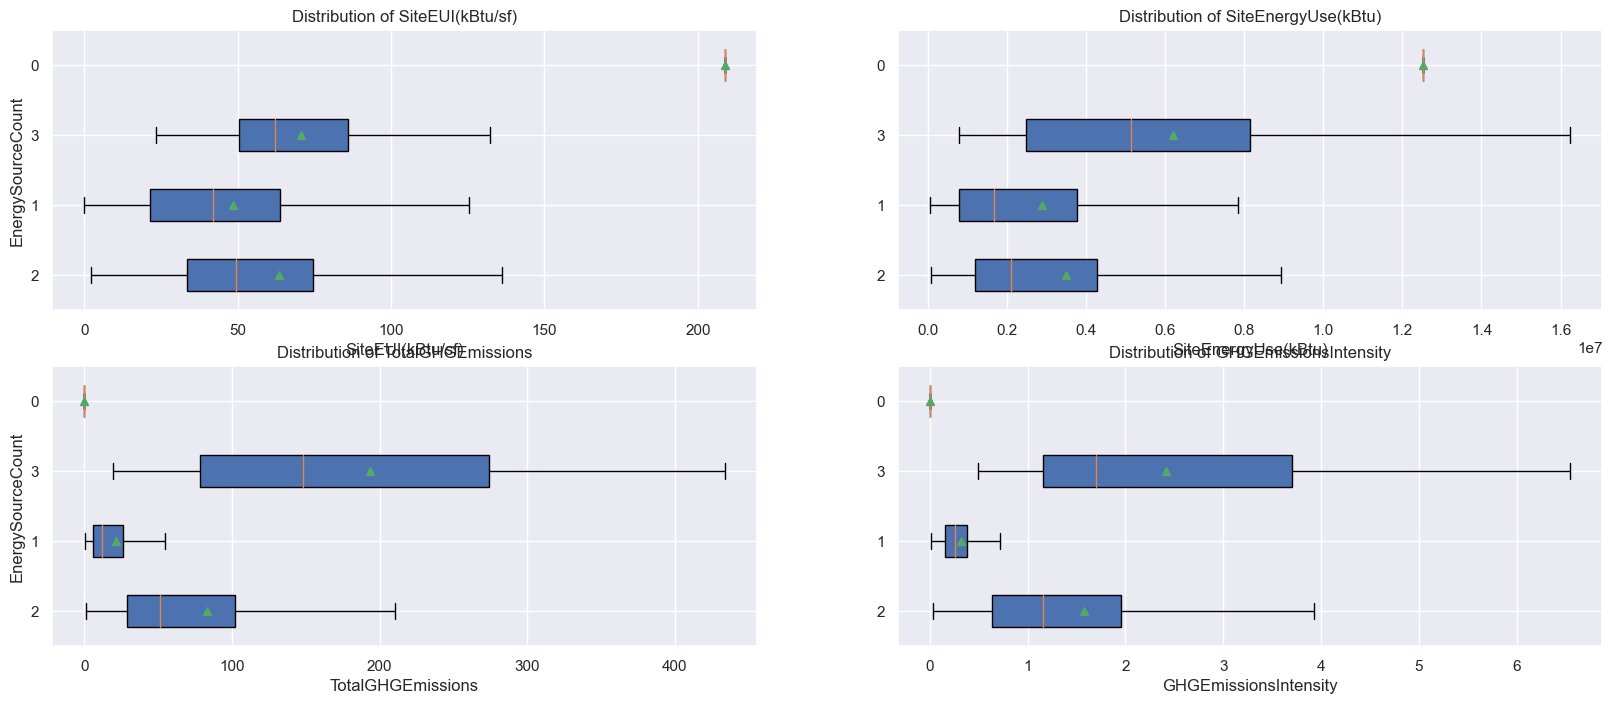

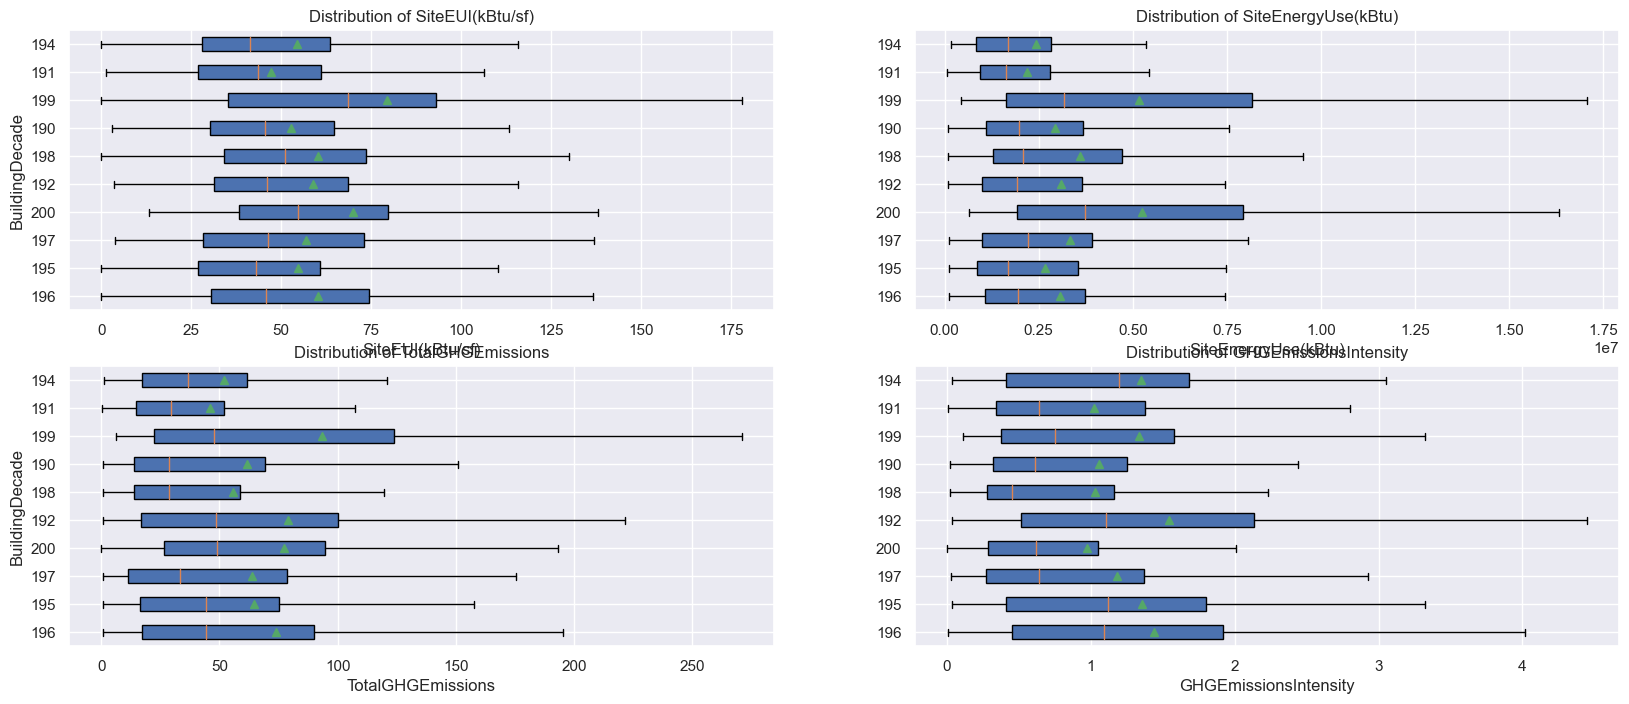

In [84]:
# Plotting the distributions of some quantitative columns for each BuildingType
columns_list=['SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
              'TotalGHGEmissions', 'GHGEmissionsIntensity']
cat_columns = ['ZipCode', 'CouncilDistrictCode', 'Neighborhood',
               'BuildingType', 'PrimaryPropertyType',
               'LargestPropertyUseType', 'SecondLargestPropertyUseType',
               'ThirdLargestPropertyUseType',
               'PropertyUseTypeCount', 'MainEnergySource',
               'EnergySourceCount', 'BuildingDecade']

distribution_of_num_for_each_categ(building_df, columns_list, cat_columns)

- Kruskal-Wallis H-test

In [85]:
# Defining Kruskal-Wallis H-test
def Kruskal_Wallis_test(df, columns_list, cat_columns):
    Kruskal_Wallis_test_df = pd.DataFrame()
    
    # Looping on the categorical column for the test
    for cat_column in cat_columns:
        
        # Defining lists for the test
        categorical_columns = []
        numerical_columns = []
        H_statistic = []
        p_value = []
        df_names = []
        categorical_columns.append(cat_column)
        
        # Performing the Kruskal-Wallis test on each numerical column
        for col in columns_list:
            # Selecting the non null data
            df_nonull = df[(df[[col, cat_column]].notna()).all(axis=1)]
            # Calculating H_statistic and p_value
            H, p = st.kruskal(*[df_nonull.loc[df_nonull[cat_column] == grp,col].values for grp in df_nonull[cat_column].unique()])
            # Appending H_statistic and p_value for future comparaison
            numerical_columns.append(col)
            H_statistic.append(H)
            p_value.append(p)
        
        name = 'Kruskal_Wallis_test_df_' + cat_column
        
        # Creating a dataframe with the H_statistic and p_value for each numerical column
        name = pd.DataFrame([H_statistic,p_value], index=['H_statistic', 'p_value'])
        name.columns = numerical_columns
        name.insert(0, 'CategoricalColumn', [cat_column, cat_column], allow_duplicates=False)
        
        # Concatunate together all dataframes corresponding to the categorical columns
        Kruskal_Wallis_test_df = pd.concat([Kruskal_Wallis_test_df, name])
    return Kruskal_Wallis_test_df

In [86]:
Kruskal_Wallis_test(building_df, columns_list, cat_columns)

CategoricalColumn  SiteEUI(kBtu/sf)  \
H_statistic                       ZipCode      1.074557e+02   
p_value                           ZipCode      7.269289e-08   
H_statistic           CouncilDistrictCode      4.333137e+01   
p_value               CouncilDistrictCode      1.002914e-07   
H_statistic                  Neighborhood      6.140892e+01   
p_value                      Neighborhood      1.208865e-06   
H_statistic                  BuildingType      7.148699e+01   
p_value                      BuildingType      2.050235e-15   
H_statistic           PrimaryPropertyType      4.274045e+02   
p_value               PrimaryPropertyType      1.189236e-81   
H_statistic        LargestPropertyUseType      4.293762e+02   
p_value            LargestPropertyUseType      7.577820e-78   
H_statistic  SecondLargestPropertyUseType      7.388256e+01   
p_value      SecondLargestPropertyUseType      1.718190e-03   
H_statistic   ThirdLargestPropertyUseType      3.562570e+01   
p_value       ThirdLargestPropertyUseType      3.015860e-01   
H_statistic          PropertyUseTypeCount      3.070239e+01   
p_value              PropertyUseTypeCount      2.153082e-07   
H_statistic              MainEnergySource      2.526713e+00   
p_value                  MainEnergySource      2.827036e-01   
H_statistic             EnergySourceCount      3.937969e+01   
p_value                 EnergySourceCount      1.442187e-08   
H_statistic                BuildingDecade      4.361738e+01   
p_value                    BuildingDecade      8.476837e-06   

             SiteEnergyUse(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  
H_statistic         1.155928e+02       9.406672e+01           8.551376e+01  
p_value             4.976453e-09       4.734998e-06           5.670074e-05  
H_statistic         3.865240e+01       2.210153e+01           3.416797e+01  
p_value             8.372799e-07       1.160629e-03           6.243138e-06  
H_statistic         6.641882e+01       3.903896e+01           5.873441e+01  
p_value             1.805731e-07       2.815525e-03           3.271380e-06  
H_statistic         1.065668e+01       3.631487e+01           4.063549e+01  
p_value             1.373489e-02       6.424059e-08           7.813149e-09  
H_statistic         4.428183e+02       2.775320e+02           2.163131e+02  
p_value             6.725689e-85       2.558995e-50           1.009420e-37  
H_statistic         3.053010e+02       1.879924e+02           2.347652e+02  
p_value             2.649940e-52       8.201291e-29           4.619342e-38  
H_statistic         1.013065e+02       4.200157e+01           6.480390e+01  
p_value             8.267882e-07       4.709062e-01           1.347963e-02  
H_statistic         6.500480e+01       3.729042e+01           3.156975e+01  
p_value             4.986926e-04       2.387332e-01           4.882233e-01  
H_statistic         2.803995e+01       4.847247e+00           4.132318e+00  
p_value             8.150852e-07       8.859999e-02           1.266714e-01  
H_statistic         5.613544e+00       1.818204e+02           3.722625e+02  
p_value             6.039966e-02       3.297693e-40           1.459590e-81  
H_statistic         3.642654e+01       4.055901e+02           5.554936e+02  
p_value             6.084035e-08       1.362323e-87          4.478834e-120  
H_statistic         9.666541e+01       3.749635e+01           4.773778e+01  
p_value             8.148456e-16       9.511647e-05           1.589846e-06

Kruskal_Wallis_test shows that all p_value are below 5% rejecting H0 hypothesis and showing that there are effect on SiteEnergyUse(kBtu) and TotalGHGEmissions from the categories in 'BuildingType', 'PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType','MainEnergySource', 'EnergySourceCount', 'PropertyUseTypeCount', and 'BuildingDecade'.

Now let's focus on what categorical columns to select for the prediction:
- PrimaryPropertyType and LargestPropertyUseType are similar, we will select PrimaryPropertyType since it has higher H_statistic and lower p_value.
- BuildingType have one order of magnitude lower H_statistic than PrimaryPropertyType. We will keep BuildingType for now and test it on the final version of the model.
- The H_statistic of ZipCode is significant and much larger than CouncilDistrictCode, and Neighborhood. We will use ZipCode instead of CouncilDistrictCode, and Neighborhood.
- We will not use directly 'SecondLargestPropertyUseType', and 'ThirdLargestPropertyUseType' since there is lot of missing values in them. We will use instead all columns ending with _GFAratio.
- The H_statistic of MainEnergySource and EnergySourceCount are low when testing on SiteEnergyUse but significant when testing on TotalGHGEmissions. We will use MainEnergySource and EnergySourceCount on TotalGHGEmissions prediction and test only EnergySourceCount on the final model for the prediction of SiteEnergyUse.
- The H_statistic of PropertyUseTypeCount is lot smaller than the other selected categorical columns. We will not use it for the TotalGHGEmissions prediction but will keep it for testing on the final model precition on SiteEnergyUse.
- The H_statistic of BuildingDecade is significant for SiteEnergyUse but that might be due to the direct correlation of buildingDecade with the GFA of the building (thsi is why we see half H_statistic for SiteEUI with BuildingDecade). We will keep it for testing on the final model of both prediction.

### <font id='Sec.4.11'> K. Final selection of features for the prediction

We will have two features set for the predictions, one without the columns ending with _GFAratio and one with columns ending with _GFAratio.

**SiteEnergyUse**:

set_1: without all columns ending with _GFAratio:
- Numerical columns:
    - PropertyGFATotal, PropertyGFABuilding, and LargestPropertyUseTypeGFA will be the main data for the prediction.
    - BuildingAge, NumberofFloors and ENERGYSTARSCORE will be tested on the final model.
- Categorical Columns:
    - PrimaryPropertyType, and ZipCode  will be the main data for the prediction.
    - BuildingType, PropertyUseTypeCount, BuildingDecade, and EnergySourceCounts will be tested on the final model.
    
set_2: with all columns ending with _GFAratio:
- Numerical columns:
    - PropertyGFATotal, PropertyGFABuilding, and all columns ending with _GFAratio will be the main data for the prediction.
    - BuildingAge, NumberofFloors and ENERGYSTARSCORE will be tested on the final model.
- Categorical Columns:
    - ZipCode  will be the main data for the prediction.
    - BuildingType, PropertyUseTypeCount, BuildingDecade, and EnergySourceCounts will be tested on the final model.
    
**TotalGHGEmissions**:

set_1: without all columns ending with _GFAratio:
- Numerical columns:
    - PropertyGFATotal, PropertyGFABuilding, LargestPropertyUseTypeGFA will be the main data for the prediction.
    - BuildingAge, NumberofFloors and ENERGYSTARSCORE will be tested on the final model.
- Categorical Columns:
    - PrimaryPropertyType, ZipCode, MainEnergySource, and EnergySourceCount will be the main data for the prediction.
    - BuildingType, and BuildingDecade will be tested on the final model.
    
set_2: with all columns ending with _GFAratio:
- Numerical columns:
    - PropertyGFATotal, PropertyGFABuilding, all columns ending with _GFAratio will be the main data for the prediction.
    - BuildingAge, NumberofFloors and ENERGYSTARSCORE will be tested on the final model.
- Categorical Columns:
    - ZipCode, MainEnergySource, and EnergySourceCount will be the main data for the prediction.
    - BuildingType, and BuildingDecade will be tested on the final model.

    
The categorical columns will be OneHotEncoded. For the numerical column (except all columns ending with _GFAratio), we will test different scaling technique: Standard scaler, RobustScaler, MinMaxScaler, and PowerTransformer.

## <font id='Sec.5'> 5. Extracting the Cleaned Dataset

In [87]:
print('Percentage of NaN in the dataset equal to',
      sum(building_df.isna().sum() / building_df.shape[0]*100) / building_df.shape[1])
df_description(building_df)

Percentage of NaN in the dataset equal to 5.280653193291119


OSEBuildingID    BuildingType          PrimaryPropertyType  \
type                    int64          object                       object   
number null               0.0             0.0                          0.0   
percentage null           0.0             0.0                          0.0   
count                  1341.0            1341                         1341   
unique                    NaN               4                           16   
top                       NaN  NonResidential  Small- and Mid-Sized Office   
freq                      NaN            1170                          289   
mean             17192.407905             NaN                          NaN   
std              12813.579527             NaN                          NaN   
min                       9.0             NaN                          NaN   
25%                     707.0             NaN                          NaN   
50%                   21425.0             NaN                          NaN   
75%                   24629.0             NaN                          NaN   
max                   50226.0             NaN                          NaN   

                PropertyName       ZipCode CouncilDistrictCode  \
type                  object       float64               int64   
number null              0.0           0.0                 0.0   
percentage null          0.0           0.0                 0.0   
count                   1341        1341.0              1341.0   
unique                  1338           NaN                 NaN   
top              Airport Way           NaN                 NaN   
freq                       2           NaN                 NaN   
mean                     NaN  98117.511559            4.155854   
std                      NaN     18.003629            2.180378   
min                      NaN       98006.0                 1.0   
25%                      NaN       98105.0                 2.0   
50%                      NaN       98115.0                 4.0   
75%                      NaN       98125.0                 7.0   
max                      NaN       98199.0                 7.0   

                     Neighborhood NumberofBuildings NumberofFloors  \
type                       object           float64        float64   
number null                   0.0               0.0            0.0   
percentage null               0.0               0.0            0.0   
count                        1341            1341.0         1341.0   
unique                         19               NaN            NaN   
top              GREATER DUWAMISH               NaN            NaN   
freq                          322               NaN            NaN   
mean                          NaN          1.054437       2.788963   
std                           NaN          0.407967       2.443278   
min                           NaN               1.0            1.0   
25%                           NaN               1.0            1.0   
50%                           NaN               1.0            2.0   
75%                           NaN               1.0            3.0   
max                           NaN               6.0           27.0   

                PropertyGFATotal PropertyGFAParking PropertyGFABuilding(s)  \
type                       int64              int64                  int64   
number null                  0.0                0.0                    0.0   
percentage null              0.0                0.0                    0.0   
count                     1341.0             1341.0                 1341.0   
unique                       NaN                NaN                    NaN   
top                          NaN                NaN                    NaN   
freq                         NaN                NaN                    NaN   
mean                65204.343028        6778.224459           58426.118568   
std                  59120.21036       23798.419674           47574.437729   
min                    

- Dropping the columns that will not be used for the prediction:

In [88]:
building_df = building_df.drop(['OSEBuildingID', 'PropertyName', 'CouncilDistrictCode',
                                'Neighborhood', 'NumberofBuildings', 'PropertyGFAParking',
                                'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
                                'PropertyName', 'SecondLargestPropertyUseType',
                                'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
                                'ThirdLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)',
                                'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
                                'GHGEmissionsIntensity', 'OtherFuel(kBtu)'], axis=1)

- Extracting the dataset:

In [89]:
print('Percentage of NaN in the dataset equal to',
      sum(building_df.isna().sum() / building_df.shape[0]*100) / building_df.shape[1])
print('The final number of columns equal to', building_df.shape[1],
      'out of the initial number of', initial_nbr_columns, 'columns.')
print('The final number of rows equal to', building_df.shape[0],
      'corresponding to', building_df.shape[0] / initial_nbr_rows*100,
      '% of the initial numbers of rows.')
building_df = building_df.reset_index(drop=True)
building_df.to_csv('building_df_cleaned.csv', sep='\t', index=False)

Percentage of NaN in the dataset equal to 0.8621160037103727
The final number of columns equal to 41 out of the initial number of 46 columns.
The final number of rows equal to 1341 corresponding to 39.72156398104265 % of the initial numbers of rows.
